uncomment if executing in google colab

In [1]:
# ! pip uninstall pyro-ppl
# ! pip install pyro-ppl==1.5.1
# ! unzip fonts.zip 
# ! unzip claptchagen.zip
# ! unzip csis
# ! cp csis.py /usr/local/lib/python3.7/dist-packages/pyro/infer

In [2]:
import random
import string
import os
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import time

from torch.autograd import Variable
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from claptchagen.claptcha import Claptcha
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from gmade import GMADE
import matplotlib.pyplot as plt
print(pyro.__version__)

captcha_folder = 'generated_captchas'
captchaHeight = 32
captchaWidth = 100
captchaMarginX = 4
captchaMarginY = 4
batch_size = 10

char_dict = string.digits
USE_CUDA = True
MAX_N = 4 # maximum number of letters in a captcha 
MIN_N = 2 # minimum number of letters in a captcha
MIN_NOISE = 0.01 # minimum noise
MAX_NOISE = 0.99 # maximum noise
smoke_test = False
num_steps = 200 if not smoke_test else 10
TrainingSample = 2000 if not smoke_test else 100 # number of captchas generated for training

def randomString():
    """
    return a string with <num_char> random letters
    """
    k = random.randint(MIN_N, MAX_N) # sample number of characters
    
    rndLetters = (random.choice(char_dict) for _ in range(k))
    
    pad_spaces = MAX_N - k # pad the string so the captcha is close to center
    space = " " * (pad_spaces // 2)
    
    return space + "".join(rndLetters) + space

def ramdomNoise():
    """
    return a float between MIN_NOISE, MAX_NOISE
    """
    return random.uniform(MIN_NOISE, MAX_NOISE)

def generate_random_captcha(n, save=False):
    """
    generate n random captchas,
    return a list of texts on the captchas
    """
    # Initialize Claptcha object with random text, FreeMono as font, of size
    # 100x30px, using bicubic resampling filter and adding a bit of white noise
    c = Claptcha(randomString, "fonts/FreeSans.ttf", (captchaWidth, captchaHeight), (captchaMarginX, captchaMarginY),
             resample=Image.BILINEAR, noise=0)
    captcha_generated = [ [] for i in range(MAX_N)]
    for i in range(n):
        c.noise = ramdomNoise()
        if save:
            text, _ = c.write(os.path.join(captcha_folder, 'captcha{}.png'.format(i)))
            os.rename(os.path.join(captcha_folder, 'captcha{}.png'.format(i)),os.path.join(captcha_folder, '{}.png'.format(text + "_" + str(i))))
        text, image = c.image
        text = text.strip()
        image = np.array(image)[:, :, 0] # the generator is gray scale, only keep one channel is enough
        captcha_generated[len(text) - 1].append((text, image, c.noise))
    return captcha_generated
    
captcha_generated = generate_random_captcha(TrainingSample, save=False)
for lst in captcha_generated:
    print("number of samples in group", len(lst))
    # print some sample captcha information generated
    for i, t in enumerate(lst):
        print("text", t[0], "captcha shape", t[1].shape, "noise", t[2])
        if i >= 10:
            break

1.7.0
number of samples in group 0
number of samples in group 666
text 01 captcha shape (32, 100) noise 0.9540929138430495
text 03 captcha shape (32, 100) noise 0.8484446158108887
text 11 captcha shape (32, 100) noise 0.7975870535885498
text 00 captcha shape (32, 100) noise 0.9011461068850017
text 96 captcha shape (32, 100) noise 0.7362663458495031
text 62 captcha shape (32, 100) noise 0.5285622164763443
text 67 captcha shape (32, 100) noise 0.5818047916462763
text 74 captcha shape (32, 100) noise 0.23488277275743924
text 93 captcha shape (32, 100) noise 0.8824493074293152
text 23 captcha shape (32, 100) noise 0.012739138090436898
text 95 captcha shape (32, 100) noise 0.41049057051953913
number of samples in group 664
text 140 captcha shape (32, 100) noise 0.3535898678907053
text 707 captcha shape (32, 100) noise 0.33233929573584
text 662 captcha shape (32, 100) noise 0.7448759519099224
text 947 captcha shape (32, 100) noise 0.7685699046451121
text 023 captcha shape (32, 100) noise 0.1

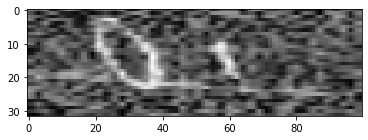

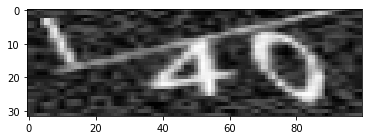

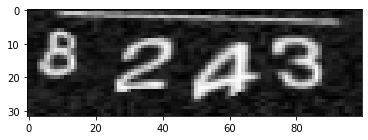

In [3]:
for lst in captcha_generated:
    if len(lst) > 0:
        plt.imshow(lst[0][1], cmap="Greys")
        plt.show()

In [4]:
def render_image(chars, fonts="fonts/FreeSans.ttf", size=(captchaWidth, captchaHeight), 
                 margin=(captchaMarginX, captchaMarginY), resample=Image.BILINEAR, noise=0.3, use_cuda=False):
    #noise = noise.data.item()
    #print(chars, noise)
    pad_spaces = MAX_N - len(chars)
    space = " " * (pad_spaces // 2)
    chars = space + chars + space
    render = Claptcha(chars, fonts, size, margin, resample=resample, noise=noise)

    
    _ , rendered_image = render.image
    rendered_image = np.array(rendered_image)[:,:,0] # the generator is gray scale, only keep one channel is enough
    rendered_image = np.subtract(np.divide(rendered_image, 255), 0.5)
    rendered_image = torch.from_numpy(rendered_image)
    if use_cuda:
        rendered_image = rendered_image.cuda()
    return rendered_image

In [5]:
class CaptchaDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, raw_captchas, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.raw_captchas = raw_captchas
        self.transform = transform

    def __len__(self):
        return len(self.raw_captchas)

    def __getitem__(self, idx):
        label = self.raw_captchas[idx][0]
        image = self.raw_captchas[idx][1]
        noise = self.raw_captchas[idx][2]
        
        image = np.subtract(np.divide(image, 255), 0.5)
        image = torch.from_numpy(image).float()

        if self.transform:
            image = self.transform(image)

        return label, image, noise

In [6]:
def make_loarders(BATCH_SIZE, raw_samples):
    dataloaders = [] # dataloaders for different num of char
    for lst in raw_samples:
        if lst:
            ds = CaptchaDataset(lst)
            dataloader = DataLoader(ds, batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=0, drop_last=True)
            dataloaders.append(dataloader)
    return dataloaders

def make_batches(dataloaders):
    all_batches = []
    for dl in dataloaders:
        for i_batch, sample in enumerate(dl):
            all_batches.append(sample)
    random.shuffle(all_batches)
    random.shuffle(all_batches)
    return all_batches

TrainLoaders = make_loarders(BATCH_SIZE=batch_size, raw_samples=captcha_generated)

In [7]:
class NoiseNet(nn.Module):

    def __init__(self, img_size, out_size = 1):
        """
        Network for learning noise in a captcha
        """
        super(NoiseNet, self).__init__()
        
        self.img_size = img_size
        self.fc0 = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.fc1 = nn.Linear(img_size[0] * img_size[1], 1024)
        
        self.fc2 = nn.Linear(1024, 1024)
        self.fc20 = nn.Linear(1024, img_size[0] * img_size[1])
        self.fc21 = nn.Linear(img_size[0] * img_size[1], out_size)
        self.softplus = nn.Softplus()
    
    def forward(self, img):
        BS = img.shape[0]
        img = img.reshape(-1, self.img_size[0] * self.img_size[1])
        hidden = F.relu(self.fc0(img))
        hidden = self.fc1(hidden)
        # mean of noise, used in normal distribution
        noise_map = self.fc20(F.relu(self.fc2(F.relu(hidden))))
        mean =  self.fc21(F.relu(noise_map))
        # std used in normal distribution
        sigma = torch.tensor([[1e-8] for _ in range(BS)]).float()
        if USE_CUDA:
            sigma = sigma.cuda()
        return mean, sigma, noise_map

In [8]:
class NumNet(nn.Module):
    def __init__(self, img_size, out_size = 3):
        """
        Network for learning N, number of letters in a captcha
        """
        super(NumNet, self).__init__()
        self.neural_net = nn.Sequential(
            nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1] * 2),
            nn.ReLU(),
            nn.Linear(img_size[0] * img_size[1] * 2, 256),
            nn.ReLU(),
            nn.Linear(256, out_size),
            nn.LogSoftmax(dim=1))
  
    def forward(self, img):
        img = torch.reshape(img, (img.shape[0], img.shape[1] * img.shape[2]))
        prob = self.neural_net(img)
        return prob

In [9]:
class InputEmbedding(nn.Module):
    def __init__(self, img_size, output_size, MAX_N):
        """
        Network for letters in a captcha, given the noise and number of letters
        """
        super(InputEmbedding, self).__init__()
        self.img_size = img_size
        
        # observe layers
        self.nnfc = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.convBN1 = nn.BatchNorm2d(64)
        self.convBN2 = nn.BatchNorm2d(64)
        self.convBN3 = nn.BatchNorm2d(64)

    def forward(self, img, noise_map):
        
        BATCH_SIZE = img.shape[0]
        # feed the noise_map to a linear layer to tune the values
        noise_map = F.relu(self.nnfc(noise_map))
        noise_map = torch.reshape(noise_map, (BATCH_SIZE, 1, self.img_size[0], self.img_size[1]))
    
        img = torch.reshape(img, (BATCH_SIZE, 1, self.img_size[0], self.img_size[1]))
        # compute the difference between original image and noise map
        # i.e. extract the unnoisy image
        img = torch.sub(img, noise_map)

        img = self.pool(F.relu(self.convBN1(self.conv1(img))))
        img = self.pool(F.relu(self.convBN2(self.conv2(img))))
        img = self.pool(F.relu(self.convBN3(self.conv3(img))))
        
        img = torch.reshape(img, (BATCH_SIZE, 1280))
        return img

In [10]:
class CharNetSingle(nn.Module):
    def __init__(self, img_size, output_size, MAX_N):
        """
        Network for letters in a captcha, given the noise and number of letters
        """
        super(CharNetSingle, self).__init__()
        self.img_size = img_size
        
        # branches
        self.pfc1 = nn.Linear(1280 + MAX_N, 2048)
        self.pfc2 = nn.Linear(2048, 1024)
        self.pfc3 = nn.Linear(1024, 1024)
        self.pfc4 = nn.Linear(1024, output_size)

    def forward(self, img_embedded, i):
        
        BATCH_SIZE = img_embedded.shape[0]
        
        # i is the index of character, use one-hot representation
        i = torch.tensor(i)
        if USE_CUDA:
            i = i.cuda()
            
        i = F.one_hot(i, num_classes=MAX_N).float()
        i = i.repeat(BATCH_SIZE, 1)
        
        img = torch.cat((img_embedded, i), 1)
        
        out = F.relu(self.pfc1(img))
        out = F.relu(self.pfc2(out))
        out = F.relu(self.pfc3(out))
        out = self.pfc4(out)
        out = F.log_softmax(out, dim=1)
        
        return out

In [11]:
def inference(t, use_cuda=False):
    """
    one epoch of inference (iterate the training set once)
    """
    start = time.time()
    loss = 0
    length = TrainingSample
    loss_group = []
    all_batches = make_batches(TrainLoaders)
    for i_batch, sample_batched in enumerate(all_batches):
        
        img = sample_batched[1]
        if use_cuda:
            img = img.cuda()
        IMG = {"captcha" : img}
        imme_loss = csis.step(observations=IMG)
        loss += imme_loss / length

    print("loss at epoch {} is {}".format(t, loss), end="; ")
    print("Epoch takes", round(time.time()- start), "seconds")
    return loss

In [12]:
def test(n = 0, use_train=False, verbose=False, use_cuda=False):
    """
    benchmarking performance on customized or training set
    """
    if use_train:
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=captcha_generated)
    else:
        test_captcha_generated = generate_random_captcha(n, save=False)
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=test_captcha_generated)
    
    total_correct = 0
    char_correct = 0
    total_char = 0
    all_batches = make_batches(TestLoaders)
    noise_difference = 0
    for i_batch, t in enumerate(all_batches):

        label = t[0][0]
        gt_noise = t[2][0]
        img = t[1]

        if use_cuda:
            img = img.cuda()
        
        IMG = {"captcha" : img}
        
        posterior = csis.run(observations=IMG)
        marginal_num = pyro.infer.EmpiricalMarginal(posterior, "num_char")
        marginal_noise = pyro.infer.EmpiricalMarginal(posterior, "noise")
        with torch.no_grad():

            N_index = marginal_num()
            N = N_index + captchaModel.num_char_domain[0]
            noise = captchaModel._map_to_noise_range(marginal_noise()[0])
            sampled_chars = []
            
            # sample characters one by one
            for i in range(N):
                marginal_char = pyro.infer.EmpiricalMarginal(posterior, "char_{}".format(i))()[0]
                if use_cuda:
                    marginal_char.cpu()
                sampled_chars.append(marginal_char)
        
        chars = ""
        for i in range(len(sampled_chars)):
            c = sampled_chars[i]
            chars +=  captchaModel.char_dict[c]
        correct = 0
        
        for p_char, t_char in zip(chars, label):
            if p_char == t_char:
                correct += 1
        noise_difference += abs(float(noise) - float(gt_noise))
        if not verbose:
            print("N_predicted:", int(N), "| Actual N:", len(label), "| Predicted Noise:", round(float(noise), 3), "| Actual Noise:", round(float(gt_noise), 3), "| Predicted Text:", chars, "| Actual Text:", label, "| Correct:", correct)
        if correct == len(label) and int(N) == len(label):
            total_correct += 1
        char_correct += correct
        total_char += len(label)
    num_test_samples = i_batch + 1
    accuracy = total_correct / num_test_samples
    char_accuracy = char_correct / total_char
    noise_difference = noise_difference / num_test_samples
    print("use_train =", use_train, "AVG Noise Difference:", noise_difference, "Total correct:", total_correct, "accuracy:{}/{}=".format(total_correct, num_test_samples), accuracy, "char_accuracy:{}/{}=".format(char_correct, total_char), char_accuracy)


In [13]:
def test_cycle(use_cuda):
    
    # disable dropout
    #captchaModel.numNet.eval()
    #captchaModel.charNetSingle.eval()
    test(use_train=True, verbose=True, use_cuda=use_cuda)
    test(1000, use_train=False, verbose=True, use_cuda=use_cuda)
    #test(10, use_train=True, verbose=False, use_cuda=use_cuda)
    test(10, use_train=False, verbose=False, use_cuda=use_cuda)
    # enable dropout
    #captchaModel.numNet.train()
    #captchaModel.charNetSingle.train()

def optimize(start_epoch=1, use_cuda=False):
    """
    Training/Inferencing Stage
    """
    loss_sequence = []
    pause = 5
    save_pause = 10
    print("Optimizing...")
    for t in range(start_epoch, num_steps + 1):
        L = inference(t, use_cuda)
        loss_sequence.append(L)
        if (t % pause == 0) and (t > 0):
            test_cycle(use_cuda=use_cuda)
        if (t % save_pause == 0) and (t > 0):
            save_and_download_checkpoints("branches-1-no-var-no-tanh_model.pt", "branches-1-no-var-no-tanh_optim.pt", "branches-1-no-var-no-tanh_param_store.pt")
    plt.plot(loss_sequence)
    plt.title("loss")
    plt.show()

In [14]:
# saves the model and optimizer states to disk
def save_checkpoint(currentModel, currentOptimzier, save_model, save_opt, save_param_store):
    print("saving model to %s..." % save_model)
    torch.save(currentModel.state_dict(), save_model)
    print("saving optimizer states to %s..." % save_opt)
    currentOptimzier.save(save_opt)
    print("saving pyro pram store states to %s..." % save_param_store)
    pyro.get_param_store().save(save_param_store)
    print("done saving checkpoints to disk.")

# loads the model and optimizer states from disk
def load_checkpoint(myModel, myOptimzer, load_model, load_opt, load_param_store):
    pyro.clear_param_store()
    print("loading model from %s..." % load_model)
    myModel.load_state_dict(torch.load(load_model))
    print("loading optimizer states from %s..." % load_opt)
    myOptimzer.load(load_opt)
    print("loading pyro pram store states from %s..." % load_param_store)
    pyro.get_param_store().load(load_param_store)
    print("done loading states.")
    pyro.module("guide", myModel, update_module_params=True)

def save_and_download_checkpoints(save_model, save_opt, save_param_store):
    save_checkpoint(captchaModel, optimiser, save_model, save_opt, save_param_store)

In [ ]:
def mask_operation(i, n):
    return i < (n + MIN_N)
    
class CaptchaModel(nn.Module):
    """
    network, model and guide wrapper class
    """
    def __init__(self, use_cuda=False):
        super().__init__()
        self.num_char_domain = torch.arange(MIN_N, MAX_N + 1)
        if use_cuda:
            self.num_char_domain = self.num_char_domain.cuda()

        self.numNet = NumNet((captchaHeight, captchaWidth), len(self.num_char_domain))
        self.noiseNet = NoiseNet((captchaHeight, captchaWidth), 1)
        self.char_dict = char_dict # letter dictionary
        self.rnn_hidden_size = 512
        self.rnn_num_layer = 2
        self.charNet = CharNetSingle((captchaHeight, captchaWidth), len(self.char_dict), max(self.num_char_domain))
        self.inputEmbedding = InputEmbedding((captchaHeight, captchaWidth), len(self.char_dict), max(self.num_char_domain))
        self.noise_constraint = torch.distributions.constraints.interval(MIN_NOISE, MAX_NOISE)
        input_dim_dict = {
            "img" : captchaHeight * captchaWidth,
            "img_embedded" : 1280,
        }
        var_dim_dict = {
            "num_char" : 1,
        }
        
        dependency_dict = {
            "num_char" : ["img"],
        }
        
        to_event_dict = {
            "num_char" : 0,
        }
        
        mask_dict = {
        }
        
        dist_type_dict = {
            "num_char" : ("cate", len(self.num_char_domain)),
        }
        
        for i in range(MAX_N):
            input_dim_dict["i_onehot_"+str(i)] = MAX_N
            input_dim_dict["i_"+str(i)] = 1
            var_dim_dict["char_"+str(i)] = 1
            dependency_dict["char_"+str(i)] = ["img_embedded", "i_onehot_"+str(i)]
            to_event_dict["char_"+str(i)] = 0
            mask_dict["char_"+str(i)] = ["i_"+str(i), "num_char", mask_operation]
            dist_type_dict["char_"+str(i)] = ("cate", len(self.char_dict))
        
        self.gmade = GMADE(input_dim_dict, dependency_dict, var_dim_dict, 
            dist_type_dict, to_event_dict, mask_dict, use_cuda=use_cuda, hidden_layers=[1,2], hidden_sizes=[1,4])
            
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
    
    def _map_to_noise_range(self, input):
        """
        map input number to the valid noise range
        """
        input = torch.distributions.transform_to(self.noise_constraint)(input)
        return input

    # update from old captcha model/guide:
    # using mask to zero out index > num_char, this is a generalization of the previous version where we take the mean 
    # and assume num_char is the same for the entire batch

    def guide(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        pyro.module("guide", self)
        img = observations["captcha"].float()
        
        # posterior to the number of letters
        
        with pyro.plate("data", img.shape[0]):
            prob = self.numNet(img)
            #prob = torch.mean(prob, dim=0)
            N_index = pyro.sample("num_char", dist.Categorical(prob).to_event(0))
            N_index = torch.add(N_index, self.num_char_domain[0])
            
            # posterior to the noise
            noise_mean, noise_sig, noise_map = self.noiseNet(img)
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)
            input_emb = self.inputEmbedding(img, noise_map)
            for i in range(MAX_N):
                sample_mask = i < N_index
                charP_i = self.charNet(input_emb, i)
                pyro.sample("char_{}".format(i), dist.Categorical(charP_i).mask(sample_mask).to_event(0))
    
    def guide_gmade(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        pyro.module("guide", self)
        
        img = observations["captcha"].float()
        BS = img.shape[0]
        # flatten representation of img
        img_raw = torch.reshape(img, (img.shape[0], img.shape[1] * img.shape[2]))
                
        with pyro.plate("data", img.shape[0]):
            # we need to sample noise seperately because the input embedding is depending on noise
            noise_mean, noise_sig, noise_map = self.noiseNet(img)
            pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            input_emb = self.inputEmbedding(img, noise_map)
            
            # We need to add manually mask = mask.cuda() in pyro.distributions.util.py <scale_and_mask>
            # mask tensor is converted from cuda back to cpu somewhere in the program even though
            # it is on cuda device when calling distritbution.mask(mask)
            # don't know the reason yet
            input_dict = {
                "img" : img_raw,
                "img_embedded" : input_emb,
            }
            
            for i in range(MAX_N):
                input_dict["i_"+str(i)] = torch.tensor(i).cuda() if self.use_cuda else torch.tensor(i)
                i_one_hot = F.one_hot(input_dict["i_"+str(i)], num_classes=MAX_N).float()
                i_one_hot = i_one_hot.repeat(BS, 1)
                input_dict["i_onehot_"+str(i)] = i_one_hot
            # num_char and char_i are sampled in GMADE
            self.gmade(input_dict, suffix="")
            
    def model(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        
        BS = observations["captcha"].shape[0]
        
        with pyro.plate("data", BS):
            
            
            num_p = torch.tensor(1 / len(self.num_char_domain)).repeat(len(self.num_char_domain)).unsqueeze(0).repeat(BS, 1)
        
            if self.use_cuda:
                num_p = num_p.cuda()

            # sample the number of characters
            N_index = pyro.sample("num_char", dist.Categorical(num_p).to_event(0))
            
            N_index = torch.add(N_index,  self.num_char_domain[0])
            
            noise_mean = torch.tensor((MAX_NOISE - MIN_NOISE) / 2).repeat((BS, 1))
            noise_sig = torch.tensor(0.5).repeat((BS, 1))

            if self.use_cuda:
                noise_mean = noise_mean.cuda()
                noise_sig = noise_sig.cuda()

            # sample the noise
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)
            
            sampled_c = []
            for i in range(MAX_N):
                sample_mask = i < N_index
                num_c_i = torch.tensor(1 / len(self.char_dict)).repeat((BS, len(self.char_dict)))
                if self.use_cuda:
                    num_c_i = num_c_i.cuda()
                c_i = pyro.sample("char_{}".format(i), dist.Categorical(num_c_i).mask(sample_mask).to_event(0))
                sampled_c.append((sample_mask, c_i))
            # sample characters
            rendered_images = []
            for i in range(BS):
                chars = ""
                for j in range(MAX_N):
                    if sampled_c[j][0][i]:
                        chars += self.char_dict[sampled_c[j][1][i]]
                    else:
                        break
                rendered_image = render_image(chars, noise=float(noise_batch[i]), use_cuda=self.use_cuda)
                rendered_images.append(rendered_image)
                
        rendered_images = torch.stack(rendered_images)
        sigma = torch.tensor(0.000001)
        if self.use_cuda:
                sigma = sigma.cuda()

        pyro.sample("captcha", dist.Normal(rendered_images, sigma).to_event(2), obs=observations["captcha"])

captchaModel = CaptchaModel(USE_CUDA)

optimiser = pyro.optim.Adam({'lr': 5e-5})
csis = pyro.infer.CSIS(captchaModel.model, captchaModel.guide_gmade, optimiser, num_inference_samples=1)


optimize(1, USE_CUDA)
test_cycle(USE_CUDA)

all_dependencies char_0 {'i_onehot_0', 'num_char', 'i_0', 'img_embedded'}
all_dependencies num_char ['img']
all_dependencies char_1 {'i_1', 'num_char', 'i_onehot_1', 'img_embedded'}
all_dependencies char_3 {'i_onehot_3', 'i_3', 'img_embedded', 'num_char'}
all_dependencies char_2 {'i_onehot_2', 'i_2', 'num_char', 'img_embedded'}
all_dependencies char_1 {'i_1', 'num_char', 'i_onehot_1', 'img_embedded'}
all_dependencies char_3 {'i_onehot_3', 'i_3', 'img_embedded', 'num_char'}
all_dependencies char_2 {'i_onehot_2', 'i_2', 'num_char', 'img_embedded'}
all_dependencies char_0 {'i_onehot_0', 'num_char', 'i_0', 'img_embedded'}
all_sets [(0,)]
input_ordering [0]
out_sets [(0,)]
out_orderings [0]
hid_orderings size 3200
num hid layers: 1
expanded_input_ordering size 3200
expanded_output_ordering size 3
all_sets [(0,), (0, 2), (1,), (1, 2), (2,), (2, 3), (2, 4), (3,), (4,)]
input_ordering [0, 2, 4, 7, 8]
out_sets [(1, 2), (2, 4), (2, 3), (0, 2)]
out_orderings [3, 6, 5, 1]
hid_orderings size 5184
n

C:\Users\frank\anaconda3\envs\pyro-env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss at epoch 1 is 1024307747321020.1; Epoch takes 134 seconds
loss at epoch 2 is 414742053564448.8; Epoch takes 140 seconds
loss at epoch 3 is 269782564612341.72; Epoch takes 139 seconds
loss at epoch 4 is 197299348569587.7; Epoch takes 134 seconds
loss at epoch 5 is 160025125202165.72; Epoch takes 132 seconds
use_train = True AVG Noise Difference: 0.0710062716266258 Total correct: 75 accuracy:75/2000= 0.0375 char_accuracy:1806/6004= 0.30079946702198535
use_train = False AVG Noise Difference: 0.07095420657537099 Total correct: 31 accuracy:31/1000= 0.031 char_accuracy:900/2980= 0.30201342281879195
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.532 | Actual Noise: 0.544 | Predicted Text: 13 | Actual Text: 14 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.676 | Actual Noise: 0.678 | Predicted Text: 389 | Actual Text: 787 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.249 | Actual Noise: 0.014 | Predicted Text: 3965 | Actual Text: 2830 | Correct: 0
N_pre

saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 21 is 53383182661451.78; Epoch takes 116 seconds
loss at epoch 22 is 51518209693581.34; Epoch takes 116 seconds
loss at epoch 23 is 47560615739129.85; Epoch takes 115 seconds
loss at epoch 24 is 47573145410863.09; Epoch takes 115 seconds
loss at epoch 25 is 50369808670392.29; Epoch takes 115 seconds
use_train = True AVG Noise Difference: 0.04061002146548166 Total correct: 708 accuracy:708/2000= 0.354 char_accuracy:4229/6004= 0.7043637574950034
use_train = False AVG Noise Difference: 0.03892490240904679 Total correct: 343 accuracy:343/1000= 0.343 char_accuracy:2125/3032= 0.7008575197889182
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.774 | Actual Noise: 0.746 | Predicted Text: 446 | Actual Text: 446 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.195 | Actual Noise: 0.077 | Predict

Logs

In [ ]:
# guide gmade 2 hidden layers for char_i, each layer has dim 2 * dim(input)
# not as good as single NN approach, suspect that the hidden dimension is too low
all_dependencies char_0 {'i_onehot_0', 'img_embedded', 'i_0', 'num_char'}
all_dependencies char_3 {'i_onehot_3', 'i_3', 'img_embedded', 'num_char'}
all_dependencies num_char ['img']
all_dependencies char_2 {'num_char', 'img_embedded', 'i_2', 'i_onehot_2'}
all_dependencies char_1 {'img_embedded', 'i_1', 'num_char', 'i_onehot_1'}
all_dependencies char_3 {'i_onehot_3', 'i_3', 'img_embedded', 'num_char'}
all_dependencies char_0 {'i_onehot_0', 'img_embedded', 'i_0', 'num_char'}
all_dependencies char_2 {'num_char', 'img_embedded', 'i_2', 'i_onehot_2'}
all_dependencies char_1 {'img_embedded', 'i_1', 'num_char', 'i_onehot_1'}
all_sets [(0,)]
input_ordering [0]
out_sets [(0,)]
out_orderings [0]
hid_orderings size 3200
num hid layers: 1
expanded_input_ordering size 3200
expanded_output_ordering size 3
all_sets [(0,), (0, 1), (1,), (1, 2), (1, 3), (1, 4), (2,), (3,), (4,)]
input_ordering [0, 2, 6, 7, 8]
out_sets [(0, 1), (1, 3), (1, 4), (1, 2)]
out_orderings [1, 4, 5, 3]
hid_orderings size 2592
num hid layers: 2
expanded_input_ordering size 1296
expanded_output_ordering size 40
number of levels: 2
input_levels [['img'], ['i_onehot_3', 'img_embedded', 'i_onehot_1', 'i_onehot_0', 'i_onehot_2']]
out_levels [['num_char'], ['char_3', 'char_0', 'char_2', 'char_1']]
Optimizing...
loss at epoch 1 is 1100905670141542.1; Epoch takes 130 seconds
loss at epoch 2 is 435760281511002.4; Epoch takes 129 seconds
loss at epoch 3 is 255536492357615.72; Epoch takes 130 seconds
loss at epoch 4 is 200201632005226.6; Epoch takes 138 seconds
loss at epoch 5 is 151765918655447.06; Epoch takes 142 seconds
use_train = True AVG Noise Difference: 0.06575049736306204 Total correct: 67 accuracy:67/2000= 0.0335 char_accuracy:1542/5981= 0.2578164186590871
use_train = False AVG Noise Difference: 0.06235535400129459 Total correct: 32 accuracy:32/1000= 0.032 char_accuracy:811/3007= 0.26970402394413034
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.649 | Actual Noise: 0.64 | Predicted Text: 4250 | Actual Text: 4934 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.6 | Actual Noise: 0.566 | Predicted Text: 3641 | Actual Text: 3611 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.302 | Actual Noise: 0.173 | Predicted Text: 482 | Actual Text: 789 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.263 | Actual Noise: 0.034 | Predicted Text: 9797 | Actual Text: 6282 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.887 | Actual Noise: 0.95 | Predicted Text: 8984 | Actual Text: 8894 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.264 | Actual Noise: 0.085 | Predicted Text: 267 | Actual Text: 287 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.416 | Actual Noise: 0.364 | Predicted Text: 7039 | Actual Text: 7938 | Correct: 2
N_predicted: 3 | Actual N: 4 | Predicted Noise: 0.287 | Actual Noise: 0.122 | Predicted Text: 816 | Actual Text: 6469 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.538 | Actual Noise: 0.528 | Predicted Text: 613 | Actual Text: 932 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.506 | Actual Noise: 0.483 | Predicted Text: 997 | Actual Text: 991 | Correct: 2
use_train = False AVG Noise Difference: 0.08933394700697127 Total correct: 0 accuracy:0/10= 0.0 char_accuracy:14/36= 0.3888888888888889
loss at epoch 6 is 130729618301780.03; Epoch takes 138 seconds
loss at epoch 7 is 116516519300563.0; Epoch takes 131 seconds
loss at epoch 8 is 112898404870258.75; Epoch takes 127 seconds
loss at epoch 9 is 87591149026934.8; Epoch takes 128 seconds
loss at epoch 10 is 86627419359805.45; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.05072673580814848 Total correct: 135 accuracy:135/2000= 0.0675 char_accuracy:2277/5981= 0.38070556763083097
use_train = False AVG Noise Difference: 0.05163484632101118 Total correct: 57 accuracy:57/1000= 0.057 char_accuracy:1132/3022= 0.3745863666446062
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.69 | Actual Noise: 0.68 | Predicted Text: 73 | Actual Text: 96 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.224 | Actual Noise: 0.074 | Predicted Text: 948 | Actual Text: 948 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.656 | Actual Noise: 0.645 | Predicted Text: 062 | Actual Text: 052 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.218 | Actual Noise: 0.091 | Predicted Text: 509 | Actual Text: 729 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.202 | Actual Noise: 0.027 | Predicted Text: 1568 | Actual Text: 3656 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.727 | Actual Noise: 0.731 | Predicted Text: 1777 | Actual Text: 4739 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.845 | Actual Noise: 0.947 | Predicted Text: 05 | Actual Text: 05 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.406 | Actual Noise: 0.408 | Predicted Text: 631 | Actual Text: 831 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.59 | Actual Noise: 0.613 | Predicted Text: 29 | Actual Text: 24 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.777 | Actual Noise: 0.774 | Predicted Text: 67 | Actual Text: 97 | Correct: 1
use_train = False AVG Noise Difference: 0.06070721657527375 Total correct: 2 accuracy:2/10= 0.2 char_accuracy:13/28= 0.4642857142857143
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 11 is 79634012328689.69; Epoch takes 128 seconds
loss at epoch 12 is 71520781897564.12; Epoch takes 129 seconds
loss at epoch 13 is 68155487017762.82; Epoch takes 128 seconds
loss at epoch 14 is 58126610571329.516; Epoch takes 130 seconds
loss at epoch 15 is 65968060755345.41; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.040999816091291046 Total correct: 241 accuracy:241/2000= 0.1205 char_accuracy:2882/5981= 0.4818592208660759
use_train = False AVG Noise Difference: 0.03781140926970081 Total correct: 128 accuracy:128/1000= 0.128 char_accuracy:1457/2993= 0.4868025392582693
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.747 | Actual Noise: 0.761 | Predicted Text: 2071 | Actual Text: 3074 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.89 | Actual Noise: 0.986 | Predicted Text: 36 | Actual Text: 35 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.377 | Actual Noise: 0.337 | Predicted Text: 605 | Actual Text: 893 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.206 | Actual Noise: 0.106 | Predicted Text: 9751 | Actual Text: 9781 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.538 | Actual Noise: 0.552 | Predicted Text: 8630 | Actual Text: 5830 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.859 | Actual Noise: 0.881 | Predicted Text: 00 | Actual Text: 08 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.702 | Actual Noise: 0.689 | Predicted Text: 025 | Actual Text: 039 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.329 | Actual Noise: 0.326 | Predicted Text: 031 | Actual Text: 031 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.856 | Actual Noise: 0.94 | Predicted Text: 873 | Actual Text: 871 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.18 | Actual Noise: 0.025 | Predicted Text: 3772 | Actual Text: 3373 | Correct: 2
use_train = False AVG Noise Difference: 0.053985108086828604 Total correct: 1 accuracy:1/10= 0.1 char_accuracy:17/32= 0.53125
loss at epoch 16 is 55536999372947.414; Epoch takes 128 seconds
loss at epoch 17 is 51587235538272.266; Epoch takes 128 seconds
loss at epoch 18 is 54337643296063.48; Epoch takes 127 seconds
loss at epoch 19 is 56630195320520.69; Epoch takes 129 seconds
loss at epoch 20 is 57401486448525.34; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.039562318333505944 Total correct: 432 accuracy:432/2000= 0.216 char_accuracy:3482/5981= 0.5821768934960709
use_train = False AVG Noise Difference: 0.03946294254088453 Total correct: 205 accuracy:205/1000= 0.205 char_accuracy:1728/2989= 0.5781197724991636
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.596 | Actual Noise: 0.616 | Predicted Text: 861 | Actual Text: 861 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.28 | Actual Noise: 0.263 | Predicted Text: 557 | Actual Text: 327 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.369 | Actual Noise: 0.366 | Predicted Text: 4269 | Actual Text: 4759 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.477 | Actual Noise: 0.481 | Predicted Text: 033 | Actual Text: 839 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.478 | Actual Noise: 0.482 | Predicted Text: 29 | Actual Text: 29 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.327 | Actual Noise: 0.3 | Predicted Text: 15 | Actual Text: 16 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.449 | Actual Noise: 0.447 | Predicted Text: 1059 | Actual Text: 9069 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.861 | Actual Noise: 0.941 | Predicted Text: 683 | Actual Text: 117 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.196 | Actual Noise: 0.073 | Predicted Text: 7834 | Actual Text: 6824 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.172 | Actual Noise: 0.014 | Predicted Text: 636 | Actual Text: 435 | Correct: 1
use_train = False AVG Noise Difference: 0.043852836218395405 Total correct: 2 accuracy:2/10= 0.2 char_accuracy:15/31= 0.4838709677419355
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 21 is 47727175927201.805; Epoch takes 127 seconds
loss at epoch 22 is 53519979276795.91; Epoch takes 128 seconds
loss at epoch 23 is 53495402638999.51; Epoch takes 128 seconds
loss at epoch 24 is 47697471491014.664; Epoch takes 129 seconds
loss at epoch 25 is 46926168013668.375; Epoch takes 130 seconds
use_train = True AVG Noise Difference: 0.0401166458528878 Total correct: 534 accuracy:534/2000= 0.267 char_accuracy:3784/5981= 0.6326701220531684
use_train = False AVG Noise Difference: 0.039295074533536235 Total correct: 275 accuracy:275/1000= 0.275 char_accuracy:1955/3063= 0.6382631407117205
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.446 | Actual Noise: 0.472 | Predicted Text: 951 | Actual Text: 951 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.517 | Actual Noise: 0.519 | Predicted Text: 5680 | Actual Text: 5581 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.301 | Actual Noise: 0.318 | Predicted Text: 908 | Actual Text: 905 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.261 | Actual Noise: 0.232 | Predicted Text: 8697 | Actual Text: 8595 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.423 | Actual Noise: 0.426 | Predicted Text: 0919 | Actual Text: 0999 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.465 | Actual Noise: 0.476 | Predicted Text: 64 | Actual Text: 64 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.431 | Actual Noise: 0.439 | Predicted Text: 67 | Actual Text: 67 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.868 | Actual Noise: 0.964 | Predicted Text: 61 | Actual Text: 51 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.329 | Actual Noise: 0.339 | Predicted Text: 259 | Actual Text: 269 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.362 | Actual Noise: 0.383 | Predicted Text: 49 | Actual Text: 49 | Correct: 2
use_train = False AVG Noise Difference: 0.022436540398429437 Total correct: 4 accuracy:4/10= 0.4 char_accuracy:21/29= 0.7241379310344828
loss at epoch 26 is 43036704043696.15; Epoch takes 128 seconds
loss at epoch 27 is 43126993200742.38; Epoch takes 128 seconds
loss at epoch 28 is 47533767363919.87; Epoch takes 129 seconds
loss at epoch 29 is 39884143572156.43; Epoch takes 128 seconds
loss at epoch 30 is 42551329500430.33; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.0348118683715945 Total correct: 637 accuracy:637/2000= 0.3185 char_accuracy:4063/5981= 0.679317839826116
use_train = False AVG Noise Difference: 0.035049994626730974 Total correct: 309 accuracy:309/1000= 0.309 char_accuracy:1971/2978= 0.6618535930154467
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.166 | Actual Noise: 0.046 | Predicted Text: 26 | Actual Text: 26 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.689 | Actual Noise: 0.693 | Predicted Text: 303 | Actual Text: 304 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.771 | Actual Noise: 0.758 | Predicted Text: 94 | Actual Text: 94 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.853 | Actual Noise: 0.867 | Predicted Text: 0434 | Actual Text: 0494 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.728 | Actual Noise: 0.7 | Predicted Text: 4275 | Actual Text: 4816 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.885 | Actual Noise: 0.91 | Predicted Text: 5799 | Actual Text: 5729 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.214 | Actual Noise: 0.131 | Predicted Text: 0374 | Actual Text: 0894 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.862 | Actual Noise: 0.931 | Predicted Text: 36 | Actual Text: 38 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.815 | Actual Noise: 0.845 | Predicted Text: 15 | Actual Text: 13 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.177 | Actual Noise: 0.06 | Predicted Text: 759 | Actual Text: 769 | Correct: 2
use_train = False AVG Noise Difference: 0.05023488264642221 Total correct: 2 accuracy:2/10= 0.2 char_accuracy:19/30= 0.6333333333333333
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 31 is 40998739886342.16; Epoch takes 128 seconds
loss at epoch 32 is 41124955273429.01; Epoch takes 128 seconds
loss at epoch 33 is 40253903137144.83; Epoch takes 130 seconds
loss at epoch 34 is 42594089692037.11; Epoch takes 131 seconds
loss at epoch 35 is 41392699961507.82; Epoch takes 131 seconds
use_train = True AVG Noise Difference: 0.04100095397981157 Total correct: 722 accuracy:722/2000= 0.361 char_accuracy:4233/5981= 0.7077411804046146
use_train = False AVG Noise Difference: 0.042773965116848264 Total correct: 366 accuracy:366/1000= 0.366 char_accuracy:2118/2987= 0.7090726481419485
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.556 | Actual Noise: 0.552 | Predicted Text: 11 | Actual Text: 12 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.726 | Actual Noise: 0.725 | Predicted Text: 2251 | Actual Text: 2251 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.894 | Actual Noise: 0.979 | Predicted Text: 9121 | Actual Text: 9121 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.355 | Actual Noise: 0.363 | Predicted Text: 9520 | Actual Text: 9528 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.719 | Actual Noise: 0.695 | Predicted Text: 993 | Actual Text: 983 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.897 | Actual Noise: 0.954 | Predicted Text: 8144 | Actual Text: 8544 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.283 | Actual Noise: 0.234 | Predicted Text: 68 | Actual Text: 64 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.814 | Actual Noise: 0.808 | Predicted Text: 958 | Actual Text: 966 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.192 | Actual Noise: 0.078 | Predicted Text: 6914 | Actual Text: 5914 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.201 | Actual Noise: 0.111 | Predicted Text: 24 | Actual Text: 24 | Correct: 2
use_train = False AVG Noise Difference: 0.04399487334846393 Total correct: 3 accuracy:3/10= 0.3 char_accuracy:24/32= 0.75
loss at epoch 36 is 40192608903757.805; Epoch takes 129 seconds
loss at epoch 37 is 35409667720609.76; Epoch takes 129 seconds
loss at epoch 38 is 37254328259444.74; Epoch takes 129 seconds
loss at epoch 39 is 35202082875179.016; Epoch takes 129 seconds
loss at epoch 40 is 35330908944859.14; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.03675017164123159 Total correct: 830 accuracy:830/2000= 0.415 char_accuracy:4431/5981= 0.7408460123725129
use_train = False AVG Noise Difference: 0.035243670770032785 Total correct: 409 accuracy:409/1000= 0.409 char_accuracy:2228/2997= 0.7434100767434101
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.627 | Actual Noise: 0.672 | Predicted Text: 0947 | Actual Text: 9947 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.528 | Actual Noise: 0.543 | Predicted Text: 9653 | Actual Text: 9663 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.233 | Actual Noise: 0.214 | Predicted Text: 1931 | Actual Text: 1431 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.165 | Actual Noise: 0.041 | Predicted Text: 81 | Actual Text: 81 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.855 | Actual Noise: 0.909 | Predicted Text: 128 | Actual Text: 428 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.227 | Actual Noise: 0.193 | Predicted Text: 597 | Actual Text: 597 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.355 | Actual Noise: 0.372 | Predicted Text: 473 | Actual Text: 473 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.868 | Actual Noise: 0.905 | Predicted Text: 58 | Actual Text: 58 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.333 | Actual Noise: 0.344 | Predicted Text: 482 | Actual Text: 482 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.88 | Actual Noise: 0.987 | Predicted Text: 23 | Actual Text: 53 | Correct: 1
use_train = False AVG Noise Difference: 0.046291830465799766 Total correct: 5 accuracy:5/10= 0.5 char_accuracy:25/30= 0.8333333333333334
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 41 is 36605920843530.22; Epoch takes 131 seconds
loss at epoch 42 is 34592942498512.89; Epoch takes 129 seconds
loss at epoch 43 is 33756782619394.055; Epoch takes 127 seconds
loss at epoch 44 is 37144460341149.69; Epoch takes 129 seconds
loss at epoch 45 is 38623929610797.04; Epoch takes 131 seconds
use_train = True AVG Noise Difference: 0.03593161507498807 Total correct: 985 accuracy:985/2000= 0.4925 char_accuracy:4696/5981= 0.7851529844507608
use_train = False AVG Noise Difference: 0.03462593113085652 Total correct: 455 accuracy:455/1000= 0.455 char_accuracy:2296/2991= 0.7676362420595119
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.521 | Actual Noise: 0.505 | Predicted Text: 871 | Actual Text: 871 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.188 | Actual Noise: 0.054 | Predicted Text: 082 | Actual Text: 082 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.218 | Actual Noise: 0.164 | Predicted Text: 983 | Actual Text: 983 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.482 | Actual Noise: 0.471 | Predicted Text: 6462 | Actual Text: 6462 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.615 | Actual Noise: 0.636 | Predicted Text: 7984 | Actual Text: 7984 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.496 | Actual Noise: 0.455 | Predicted Text: 1483 | Actual Text: 1443 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.885 | Actual Noise: 0.944 | Predicted Text: 311 | Actual Text: 617 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.504 | Actual Noise: 0.485 | Predicted Text: 61 | Actual Text: 61 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.851 | Actual Noise: 0.884 | Predicted Text: 96 | Actual Text: 98 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.357 | Actual Noise: 0.36 | Predicted Text: 5362 | Actual Text: 5362 | Correct: 4
use_train = False AVG Noise Difference: 0.03931047936679895 Total correct: 7 accuracy:7/10= 0.7 char_accuracy:28/32= 0.875
loss at epoch 46 is 33160877985497.09; Epoch takes 129 seconds
loss at epoch 47 is 32615204753178.617; Epoch takes 130 seconds
loss at epoch 48 is 33894790688014.34; Epoch takes 127 seconds
loss at epoch 49 is 34685306880393.207; Epoch takes 128 seconds
loss at epoch 50 is 35579903707578.38; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.03664581125634785 Total correct: 1059 accuracy:1059/2000= 0.5295 char_accuracy:4810/5981= 0.8042133422504598
use_train = False AVG Noise Difference: 0.03696417781031324 Total correct: 508 accuracy:508/1000= 0.508 char_accuracy:2405/3012= 0.798472775564409
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.263 | Actual Noise: 0.239 | Predicted Text: 27 | Actual Text: 27 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.424 | Actual Noise: 0.429 | Predicted Text: 36 | Actual Text: 15 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.84 | Actual Noise: 0.869 | Predicted Text: 5312 | Actual Text: 5512 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.183 | Actual Noise: 0.092 | Predicted Text: 45 | Actual Text: 10 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.204 | Actual Noise: 0.117 | Predicted Text: 1262 | Actual Text: 1862 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.613 | Actual Noise: 0.625 | Predicted Text: 535 | Actual Text: 536 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.261 | Actual Noise: 0.219 | Predicted Text: 1442 | Actual Text: 1442 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.828 | Actual Noise: 0.828 | Predicted Text: 979 | Actual Text: 979 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.648 | Actual Noise: 0.631 | Predicted Text: 20 | Actual Text: 20 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.8 | Actual Noise: 0.848 | Predicted Text: 02 | Actual Text: 02 | Correct: 2
use_train = False AVG Noise Difference: 0.035617660273006155 Total correct: 5 accuracy:5/10= 0.5 char_accuracy:21/28= 0.75
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 51 is 33184611065397.24; Epoch takes 128 seconds
loss at epoch 52 is 31079771809251.32; Epoch takes 129 seconds
loss at epoch 53 is 32324289339588.633; Epoch takes 129 seconds
loss at epoch 54 is 33054894796308.473; Epoch takes 128 seconds
loss at epoch 55 is 31454927726051.332; Epoch takes 130 seconds
use_train = True AVG Noise Difference: 0.03487263454225333 Total correct: 1176 accuracy:1176/2000= 0.588 char_accuracy:4998/5981= 0.8356462130078582
use_train = False AVG Noise Difference: 0.03517627485432212 Total correct: 570 accuracy:570/1000= 0.57 char_accuracy:2508/3027= 0.8285431119920713
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.463 | Actual Noise: 0.463 | Predicted Text: 547 | Actual Text: 547 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.244 | Actual Noise: 0.217 | Predicted Text: 7660 | Actual Text: 7660 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.449 | Actual Noise: 0.453 | Predicted Text: 28 | Actual Text: 28 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.182 | Actual Noise: 0.09 | Predicted Text: 94 | Actual Text: 99 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.578 | Actual Noise: 0.583 | Predicted Text: 21 | Actual Text: 49 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.443 | Actual Noise: 0.446 | Predicted Text: 2079 | Actual Text: 2079 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.207 | Actual Noise: 0.141 | Predicted Text: 977 | Actual Text: 977 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.875 | Actual Noise: 0.946 | Predicted Text: 0043 | Actual Text: 0043 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.313 | Actual Noise: 0.287 | Predicted Text: 944 | Actual Text: 944 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.32 | Actual Noise: 0.317 | Predicted Text: 3535 | Actual Text: 3535 | Correct: 4
use_train = False AVG Noise Difference: 0.029974202482793748 Total correct: 8 accuracy:8/10= 0.8 char_accuracy:28/31= 0.9032258064516129
loss at epoch 56 is 33822376988639.22; Epoch takes 128 seconds
loss at epoch 57 is 34059323893612.54; Epoch takes 127 seconds
loss at epoch 58 is 32134109399220.234; Epoch takes 128 seconds
loss at epoch 59 is 32740710370508.797; Epoch takes 128 seconds
loss at epoch 60 is 27848887779196.926; Epoch takes 130 seconds
use_train = True AVG Noise Difference: 0.034078273432348066 Total correct: 1289 accuracy:1289/2000= 0.6445 char_accuracy:5145/5981= 0.860224042802207
use_train = False AVG Noise Difference: 0.03305946462854977 Total correct: 621 accuracy:621/1000= 0.621 char_accuracy:2542/2999= 0.8476158719573191
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.258 | Actual Noise: 0.234 | Predicted Text: 34 | Actual Text: 34 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.261 | Actual Noise: 0.237 | Predicted Text: 6185 | Actual Text: 6185 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.263 | Actual Noise: 0.232 | Predicted Text: 374 | Actual Text: 374 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.845 | Actual Noise: 0.877 | Predicted Text: 81 | Actual Text: 01 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.458 | Actual Noise: 0.447 | Predicted Text: 84 | Actual Text: 89 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.17 | Actual Noise: 0.038 | Predicted Text: 662 | Actual Text: 667 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.872 | Actual Noise: 0.926 | Predicted Text: 7562 | Actual Text: 7562 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.532 | Actual Noise: 0.543 | Predicted Text: 3927 | Actual Text: 3927 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.236 | Actual Noise: 0.206 | Predicted Text: 12 | Actual Text: 12 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.636 | Actual Noise: 0.655 | Predicted Text: 119 | Actual Text: 110 | Correct: 2
use_train = False AVG Noise Difference: 0.03688237717156754 Total correct: 6 accuracy:6/10= 0.6 char_accuracy:25/29= 0.8620689655172413
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 61 is 29979974982041.617; Epoch takes 131 seconds
loss at epoch 62 is 31736916825276.414; Epoch takes 129 seconds
loss at epoch 63 is 30142048739524.6; Epoch takes 130 seconds
loss at epoch 64 is 31448645405900.766; Epoch takes 127 seconds
loss at epoch 65 is 29078627450093.56; Epoch takes 130 seconds
use_train = True AVG Noise Difference: 0.03373780562590876 Total correct: 1329 accuracy:1329/2000= 0.6645 char_accuracy:5207/5981= 0.8705902023073064
use_train = False AVG Noise Difference: 0.034422523869908045 Total correct: 688 accuracy:688/1000= 0.688 char_accuracy:2638/2995= 0.8808013355592654
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.888 | Actual Noise: 0.952 | Predicted Text: 3455 | Actual Text: 7455 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.334 | Actual Noise: 0.334 | Predicted Text: 597 | Actual Text: 597 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.616 | Actual Noise: 0.631 | Predicted Text: 0255 | Actual Text: 0255 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.744 | Actual Noise: 0.725 | Predicted Text: 514 | Actual Text: 514 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.73 | Actual Noise: 0.728 | Predicted Text: 772 | Actual Text: 702 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.863 | Actual Noise: 0.883 | Predicted Text: 54 | Actual Text: 64 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.406 | Actual Noise: 0.372 | Predicted Text: 872 | Actual Text: 822 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.17 | Actual Noise: 0.012 | Predicted Text: 3686 | Actual Text: 3986 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.224 | Actual Noise: 0.179 | Predicted Text: 920 | Actual Text: 020 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.637 | Actual Noise: 0.601 | Predicted Text: 547 | Actual Text: 747 | Correct: 2
use_train = False AVG Noise Difference: 0.039541266343216065 Total correct: 3 accuracy:3/10= 0.3 char_accuracy:25/32= 0.78125
loss at epoch 66 is 35014220157419.54; Epoch takes 128 seconds
loss at epoch 67 is 29384275610828.785; Epoch takes 128 seconds
loss at epoch 68 is 28926045284466.69; Epoch takes 127 seconds
loss at epoch 69 is 30506226867896.312; Epoch takes 126 seconds
loss at epoch 70 is 29123221209612.297; Epoch takes 130 seconds
use_train = True AVG Noise Difference: 0.03278601401652045 Total correct: 1396 accuracy:1396/2000= 0.698 char_accuracy:5296/5981= 0.8854706570807557
use_train = False AVG Noise Difference: 0.030099315911704033 Total correct: 670 accuracy:670/1000= 0.67 char_accuracy:2625/3010= 0.872093023255814
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.857 | Actual Noise: 0.885 | Predicted Text: 74 | Actual Text: 74 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.317 | Actual Noise: 0.313 | Predicted Text: 616 | Actual Text: 676 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.231 | Actual Noise: 0.195 | Predicted Text: 23 | Actual Text: 23 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.574 | Actual Noise: 0.579 | Predicted Text: 1513 | Actual Text: 1513 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.164 | Actual Noise: 0.029 | Predicted Text: 78 | Actual Text: 78 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.884 | Actual Noise: 0.926 | Predicted Text: 96 | Actual Text: 95 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.19 | Actual Noise: 0.1 | Predicted Text: 6411 | Actual Text: 6411 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.339 | Actual Noise: 0.332 | Predicted Text: 1913 | Actual Text: 1913 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.306 | Actual Noise: 0.284 | Predicted Text: 734 | Actual Text: 734 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.477 | Actual Noise: 0.471 | Predicted Text: 289 | Actual Text: 989 | Correct: 2
use_train = False AVG Noise Difference: 0.03747197154920175 Total correct: 7 accuracy:7/10= 0.7 char_accuracy:26/29= 0.896551724137931
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 71 is 32113457549934.605; Epoch takes 127 seconds
loss at epoch 72 is 31254593738375.176; Epoch takes 129 seconds
loss at epoch 73 is 28424516370563.08; Epoch takes 128 seconds
loss at epoch 74 is 30150668542279.676; Epoch takes 128 seconds
loss at epoch 75 is 28491366044401.656; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.03455084839986126 Total correct: 1371 accuracy:1371/2000= 0.6855 char_accuracy:5268/5981= 0.880789165691356
use_train = False AVG Noise Difference: 0.03385967583203985 Total correct: 701 accuracy:701/1000= 0.701 char_accuracy:2690/3033= 0.8869106495219254
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.197 | Actual Noise: 0.115 | Predicted Text: 231 | Actual Text: 231 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.8 | Actual Noise: 0.805 | Predicted Text: 959 | Actual Text: 959 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.482 | Actual Noise: 0.459 | Predicted Text: 859 | Actual Text: 859 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.752 | Actual Noise: 0.76 | Predicted Text: 83 | Actual Text: 83 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.195 | Actual Noise: 0.062 | Predicted Text: 875 | Actual Text: 875 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.405 | Actual Noise: 0.387 | Predicted Text: 7430 | Actual Text: 7430 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.78 | Actual Noise: 0.789 | Predicted Text: 77 | Actual Text: 77 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.897 | Actual Noise: 0.979 | Predicted Text: 7175 | Actual Text: 7175 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.544 | Actual Noise: 0.542 | Predicted Text: 104 | Actual Text: 104 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.455 | Actual Noise: 0.452 | Predicted Text: 93 | Actual Text: 33 | Correct: 1
use_train = False AVG Noise Difference: 0.036470112217497505 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:28/29= 0.9655172413793104
loss at epoch 76 is 31766035037683.723; Epoch takes 129 seconds
loss at epoch 77 is 28009017183043.598; Epoch takes 127 seconds
loss at epoch 78 is 28612656199499.77; Epoch takes 129 seconds
loss at epoch 79 is 27755175435698.188; Epoch takes 127 seconds
loss at epoch 80 is 29073996714344.42; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.03255495242009825 Total correct: 1459 accuracy:1459/2000= 0.7295 char_accuracy:5366/5981= 0.8971743855542551
use_train = False AVG Noise Difference: 0.03348559784708731 Total correct: 723 accuracy:723/1000= 0.723 char_accuracy:2736/3056= 0.8952879581151832
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.228 | Actual Noise: 0.207 | Predicted Text: 1009 | Actual Text: 2009 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.589 | Actual Noise: 0.578 | Predicted Text: 95 | Actual Text: 95 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.233 | Actual Noise: 0.204 | Predicted Text: 057 | Actual Text: 057 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.871 | Actual Noise: 0.874 | Predicted Text: 8761 | Actual Text: 8758 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.324 | Actual Noise: 0.315 | Predicted Text: 841 | Actual Text: 841 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.236 | Actual Noise: 0.206 | Predicted Text: 359 | Actual Text: 358 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.585 | Actual Noise: 0.596 | Predicted Text: 2946 | Actual Text: 2946 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.311 | Actual Noise: 0.309 | Predicted Text: 14 | Actual Text: 14 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.173 | Actual Noise: 0.057 | Predicted Text: 491 | Actual Text: 491 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.187 | Actual Noise: 0.093 | Predicted Text: 7672 | Actual Text: 7672 | Correct: 4
use_train = False AVG Noise Difference: 0.03270642767860864 Total correct: 7 accuracy:7/10= 0.7 char_accuracy:28/32= 0.875
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 81 is 28066625558282.246; Epoch takes 127 seconds
loss at epoch 82 is 28768685194870.777; Epoch takes 128 seconds
loss at epoch 83 is 28885327226601.477; Epoch takes 127 seconds
loss at epoch 84 is 27080178640617.477; Epoch takes 129 seconds
loss at epoch 85 is 26827468266143.734; Epoch takes 130 seconds
use_train = True AVG Noise Difference: 0.031140383048019665 Total correct: 1516 accuracy:1516/2000= 0.758 char_accuracy:5437/5981= 0.9090453101488045
use_train = False AVG Noise Difference: 0.030234510045768093 Total correct: 759 accuracy:759/1000= 0.759 char_accuracy:2735/3001= 0.9113628790403199
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.859 | Actual Noise: 0.879 | Predicted Text: 12 | Actual Text: 12 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.501 | Actual Noise: 0.517 | Predicted Text: 4341 | Actual Text: 4348 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.857 | Actual Noise: 0.857 | Predicted Text: 9472 | Actual Text: 9472 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.894 | Actual Noise: 0.958 | Predicted Text: 503 | Actual Text: 593 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.16 | Actual Noise: 0.011 | Predicted Text: 65 | Actual Text: 65 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.59 | Actual Noise: 0.579 | Predicted Text: 434 | Actual Text: 434 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.881 | Actual Noise: 0.909 | Predicted Text: 936 | Actual Text: 936 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.402 | Actual Noise: 0.394 | Predicted Text: 9115 | Actual Text: 9115 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.887 | Actual Noise: 0.933 | Predicted Text: 75 | Actual Text: 75 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.186 | Actual Noise: 0.1 | Predicted Text: 020 | Actual Text: 020 | Correct: 3
use_train = False AVG Noise Difference: 0.04288534118291427 Total correct: 8 accuracy:8/10= 0.8 char_accuracy:28/30= 0.9333333333333333
loss at epoch 86 is 27747749356503.047; Epoch takes 127 seconds
loss at epoch 87 is 26869483032018.945; Epoch takes 127 seconds
loss at epoch 88 is 26184158287101.953; Epoch takes 127 seconds
loss at epoch 89 is 30075873169899.51; Epoch takes 128 seconds
loss at epoch 90 is 29510333287366.664; Epoch takes 132 seconds
use_train = True AVG Noise Difference: 0.03426551051828202 Total correct: 1500 accuracy:1500/2000= 0.75 char_accuracy:5434/5981= 0.9085437217856546
use_train = False AVG Noise Difference: 0.03267552198641428 Total correct: 753 accuracy:753/1000= 0.753 char_accuracy:2718/2998= 0.9066044029352902
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.386 | Actual Noise: 0.373 | Predicted Text: 465 | Actual Text: 465 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.706 | Actual Noise: 0.698 | Predicted Text: 2851 | Actual Text: 2851 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.412 | Actual Noise: 0.415 | Predicted Text: 771 | Actual Text: 771 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.266 | Actual Noise: 0.244 | Predicted Text: 03 | Actual Text: 03 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.198 | Actual Noise: 0.105 | Predicted Text: 91 | Actual Text: 91 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.312 | Actual Noise: 0.295 | Predicted Text: 9326 | Actual Text: 9326 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.193 | Actual Noise: 0.078 | Predicted Text: 391 | Actual Text: 391 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.617 | Actual Noise: 0.602 | Predicted Text: 534 | Actual Text: 524 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.873 | Actual Noise: 0.892 | Predicted Text: 79 | Actual Text: 79 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.859 | Actual Noise: 0.845 | Predicted Text: 3548 | Actual Text: 3648 | Correct: 3
use_train = False AVG Noise Difference: 0.03179912028830971 Total correct: 8 accuracy:8/10= 0.8 char_accuracy:28/30= 0.9333333333333333
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 91 is 26844980175699.98; Epoch takes 130 seconds
loss at epoch 92 is 26685801280438.266; Epoch takes 127 seconds
loss at epoch 93 is 26987869129801.742; Epoch takes 127 seconds
loss at epoch 94 is 26199122826887.18; Epoch takes 128 seconds
loss at epoch 95 is 26521731360817.15; Epoch takes 131 seconds
use_train = True AVG Noise Difference: 0.032912502282855416 Total correct: 1575 accuracy:1575/2000= 0.7875 char_accuracy:5517/5981= 0.9224209998328039
use_train = False AVG Noise Difference: 0.029985916875561156 Total correct: 760 accuracy:760/1000= 0.76 char_accuracy:2776/3042= 0.9125575279421433
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.698 | Actual Noise: 0.694 | Predicted Text: 0711 | Actual Text: 0711 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.232 | Actual Noise: 0.182 | Predicted Text: 9706 | Actual Text: 9706 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.838 | Actual Noise: 0.857 | Predicted Text: 0575 | Actual Text: 0575 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.841 | Actual Noise: 0.86 | Predicted Text: 94 | Actual Text: 94 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.404 | Actual Noise: 0.402 | Predicted Text: 505 | Actual Text: 505 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.574 | Actual Noise: 0.558 | Predicted Text: 2351 | Actual Text: 2351 | Correct: 4
N_predicted: 2 | Actual N: 3 | Predicted Noise: 0.191 | Actual Noise: 0.081 | Predicted Text: 42 | Actual Text: 420 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.202 | Actual Noise: 0.136 | Predicted Text: 15 | Actual Text: 15 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.224 | Actual Noise: 0.193 | Predicted Text: 36 | Actual Text: 86 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.683 | Actual Noise: 0.696 | Predicted Text: 306 | Actual Text: 306 | Correct: 3
use_train = False AVG Noise Difference: 0.03266394670419741 Total correct: 8 accuracy:8/10= 0.8 char_accuracy:29/31= 0.9354838709677419
loss at epoch 96 is 29915599740010.523; Epoch takes 127 seconds
loss at epoch 97 is 28640386579562.492; Epoch takes 127 seconds
loss at epoch 98 is 26323008751271.938; Epoch takes 128 seconds
loss at epoch 99 is 28623606715383.793; Epoch takes 127 seconds
loss at epoch 100 is 26735367925006.32; Epoch takes 128 seconds
use_train = True AVG Noise Difference: 0.03250013372830836 Total correct: 1555 accuracy:1555/2000= 0.7775 char_accuracy:5492/5981= 0.9182410968065541
use_train = False AVG Noise Difference: 0.03267938308059471 Total correct: 777 accuracy:777/1000= 0.777 char_accuracy:2803/3044= 0.9208278580814717
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.272 | Actual Noise: 0.264 | Predicted Text: 4848 | Actual Text: 4848 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.296 | Actual Noise: 0.287 | Predicted Text: 1011 | Actual Text: 1011 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.378 | Actual Noise: 0.366 | Predicted Text: 82 | Actual Text: 82 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.312 | Actual Noise: 0.312 | Predicted Text: 03 | Actual Text: 03 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.279 | Actual Noise: 0.261 | Predicted Text: 97 | Actual Text: 97 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.638 | Actual Noise: 0.667 | Predicted Text: 20 | Actual Text: 20 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.192 | Actual Noise: 0.112 | Predicted Text: 7601 | Actual Text: 7601 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.387 | Actual Noise: 0.4 | Predicted Text: 19 | Actual Text: 19 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.383 | Actual Noise: 0.372 | Predicted Text: 769 | Actual Text: 769 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.738 | Actual Noise: 0.772 | Predicted Text: 579 | Actual Text: 579 | Correct: 3
use_train = False AVG Noise Difference: 0.021291993283488967 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:28/28= 1.0
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 101 is 26107777282211.824; Epoch takes 127 seconds
loss at epoch 102 is 26287481140805.63; Epoch takes 131 seconds
loss at epoch 103 is 27529445724389.38; Epoch takes 127 seconds
loss at epoch 104 is 27823403483267.074; Epoch takes 128 seconds
loss at epoch 105 is 26492452582195.203; Epoch takes 128 seconds
use_train = True AVG Noise Difference: 0.031428255925132924 Total correct: 1616 accuracy:1616/2000= 0.808 char_accuracy:5561/5981= 0.9297776291590035
use_train = False AVG Noise Difference: 0.030946569897018446 Total correct: 797 accuracy:797/1000= 0.797 char_accuracy:2778/3002= 0.9253830779480346
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.815 | Actual Noise: 0.86 | Predicted Text: 792 | Actual Text: 792 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.444 | Actual Noise: 0.43 | Predicted Text: 6040 | Actual Text: 6040 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.231 | Actual Noise: 0.203 | Predicted Text: 7125 | Actual Text: 7125 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.367 | Actual Noise: 0.33 | Predicted Text: 7447 | Actual Text: 7447 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.799 | Actual Noise: 0.812 | Predicted Text: 80 | Actual Text: 80 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.329 | Actual Noise: 0.307 | Predicted Text: 970 | Actual Text: 970 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.741 | Actual Noise: 0.737 | Predicted Text: 630 | Actual Text: 630 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.178 | Actual Noise: 0.035 | Predicted Text: 649 | Actual Text: 649 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.472 | Actual Noise: 0.483 | Predicted Text: 9298 | Actual Text: 9298 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.757 | Actual Noise: 0.739 | Predicted Text: 084 | Actual Text: 084 | Correct: 3
use_train = False AVG Noise Difference: 0.03369883297983335 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:33/33= 1.0
loss at epoch 106 is 26194684881797.117; Epoch takes 128 seconds
loss at epoch 107 is 28066000034988.035; Epoch takes 128 seconds
loss at epoch 108 is 26492010129195.01; Epoch takes 126 seconds
loss at epoch 109 is 28501643010965.508; Epoch takes 130 seconds
loss at epoch 110 is 27102146093187.082; Epoch takes 128 seconds
use_train = True AVG Noise Difference: 0.037158072520420075 Total correct: 1603 accuracy:1603/2000= 0.8015 char_accuracy:5541/5981= 0.9264337067380036
use_train = False AVG Noise Difference: 0.03616437392808322 Total correct: 806 accuracy:806/1000= 0.806 char_accuracy:2828/3035= 0.9317957166392092
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.326 | Actual Noise: 0.311 | Predicted Text: 6546 | Actual Text: 6546 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.85 | Actual Noise: 0.874 | Predicted Text: 192 | Actual Text: 192 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.286 | Actual Noise: 0.248 | Predicted Text: 6238 | Actual Text: 6238 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.185 | Actual Noise: 0.061 | Predicted Text: 697 | Actual Text: 697 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.185 | Actual Noise: 0.062 | Predicted Text: 149 | Actual Text: 140 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.829 | Actual Noise: 0.858 | Predicted Text: 09 | Actual Text: 09 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.621 | Actual Noise: 0.619 | Predicted Text: 7268 | Actual Text: 7269 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.887 | Actual Noise: 0.926 | Predicted Text: 21 | Actual Text: 21 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.611 | Actual Noise: 0.592 | Predicted Text: 24 | Actual Text: 24 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.181 | Actual Noise: 0.04 | Predicted Text: 652 | Actual Text: 652 | Correct: 3
use_train = False AVG Noise Difference: 0.055356827420970145 Total correct: 8 accuracy:8/10= 0.8 char_accuracy:28/30= 0.9333333333333333
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 111 is 26232050871697.41; Epoch takes 128 seconds
loss at epoch 112 is 26089858655453.164; Epoch takes 127 seconds
loss at epoch 113 is 26447335490715.63; Epoch takes 127 seconds
loss at epoch 114 is 25105513514008.574; Epoch takes 128 seconds
loss at epoch 115 is 26448748518703.094; Epoch takes 128 seconds
use_train = True AVG Noise Difference: 0.0316081002381334 Total correct: 1664 accuracy:1664/2000= 0.832 char_accuracy:5615/5981= 0.9388062196957031
use_train = False AVG Noise Difference: 0.030484121681315438 Total correct: 806 accuracy:806/1000= 0.806 char_accuracy:2789/2997= 0.9305972639305973
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.866 | Actual Noise: 0.916 | Predicted Text: 748 | Actual Text: 148 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.869 | Actual Noise: 0.901 | Predicted Text: 612 | Actual Text: 612 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.924 | Actual Noise: 0.986 | Predicted Text: 52 | Actual Text: 52 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.204 | Actual Noise: 0.149 | Predicted Text: 39 | Actual Text: 39 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.183 | Actual Noise: 0.059 | Predicted Text: 996 | Actual Text: 996 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.469 | Actual Noise: 0.468 | Predicted Text: 5591 | Actual Text: 5591 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.266 | Actual Noise: 0.263 | Predicted Text: 07 | Actual Text: 07 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.833 | Actual Noise: 0.836 | Predicted Text: 161 | Actual Text: 161 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.901 | Actual Noise: 0.984 | Predicted Text: 45 | Actual Text: 45 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.197 | Actual Noise: 0.104 | Predicted Text: 8454 | Actual Text: 8454 | Correct: 4
use_train = False AVG Noise Difference: 0.050368136386426676 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:27/28= 0.9642857142857143
loss at epoch 116 is 24698391600431.098; Epoch takes 129 seconds
loss at epoch 117 is 27799175472218.105; Epoch takes 127 seconds
loss at epoch 118 is 25811588935843.816; Epoch takes 129 seconds
loss at epoch 119 is 24524538762362.887; Epoch takes 128 seconds
loss at epoch 120 is 26279644119957.492; Epoch takes 130 seconds
use_train = True AVG Noise Difference: 0.032104779357887823 Total correct: 1653 accuracy:1653/2000= 0.8265 char_accuracy:5605/5981= 0.9371342584852032
use_train = False AVG Noise Difference: 0.031006057669213553 Total correct: 827 accuracy:827/1000= 0.827 char_accuracy:2798/2991= 0.93547308592444
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.277 | Actual Noise: 0.254 | Predicted Text: 2088 | Actual Text: 2088 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.263 | Actual Noise: 0.25 | Predicted Text: 10 | Actual Text: 10 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.784 | Actual Noise: 0.784 | Predicted Text: 39 | Actual Text: 59 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.579 | Actual Noise: 0.562 | Predicted Text: 516 | Actual Text: 516 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.366 | Actual Noise: 0.377 | Predicted Text: 254 | Actual Text: 254 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.318 | Actual Noise: 0.314 | Predicted Text: 66 | Actual Text: 66 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.635 | Actual Noise: 0.64 | Predicted Text: 3074 | Actual Text: 3074 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.346 | Actual Noise: 0.363 | Predicted Text: 3153 | Actual Text: 3153 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.815 | Actual Noise: 0.836 | Predicted Text: 9762 | Actual Text: 9762 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.284 | Actual Noise: 0.277 | Predicted Text: 909 | Actual Text: 909 | Correct: 3
use_train = False AVG Noise Difference: 0.011880307484944291 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:30/31= 0.967741935483871
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 121 is 26698087118929.92; Epoch takes 127 seconds
loss at epoch 122 is 26822195381403.65; Epoch takes 127 seconds
loss at epoch 123 is 25060788183826.438; Epoch takes 126 seconds
loss at epoch 124 is 27070176779698.195; Epoch takes 128 seconds
loss at epoch 125 is 26491702670786.57; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.03171367563672166 Total correct: 1644 accuracy:1644/2000= 0.822 char_accuracy:5606/5981= 0.9373014546062531
use_train = False AVG Noise Difference: 0.03182532665525572 Total correct: 847 accuracy:847/1000= 0.847 char_accuracy:2840/3003= 0.9457209457209457
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.171 | Actual Noise: 0.056 | Predicted Text: 56 | Actual Text: 56 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.504 | Actual Noise: 0.501 | Predicted Text: 1817 | Actual Text: 1817 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.39 | Actual Noise: 0.382 | Predicted Text: 741 | Actual Text: 744 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.223 | Actual Noise: 0.194 | Predicted Text: 834 | Actual Text: 834 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.412 | Actual Noise: 0.432 | Predicted Text: 9801 | Actual Text: 9801 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.902 | Actual Noise: 0.988 | Predicted Text: 47 | Actual Text: 17 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.494 | Actual Noise: 0.527 | Predicted Text: 91 | Actual Text: 91 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.857 | Actual Noise: 0.866 | Predicted Text: 9377 | Actual Text: 9377 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.907 | Actual Noise: 0.959 | Predicted Text: 9218 | Actual Text: 9218 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.727 | Actual Noise: 0.722 | Predicted Text: 75 | Actual Text: 75 | Correct: 2
use_train = False AVG Noise Difference: 0.03596146276435673 Total correct: 8 accuracy:8/10= 0.8 char_accuracy:28/30= 0.9333333333333333
loss at epoch 126 is 26725683200131.098; Epoch takes 128 seconds
loss at epoch 127 is 23628926698061.824; Epoch takes 132 seconds
loss at epoch 128 is 24395667603587.082; Epoch takes 129 seconds
loss at epoch 129 is 26898034438832.133; Epoch takes 128 seconds
loss at epoch 130 is 26752522571022.34; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.03719558497326777 Total correct: 1690 accuracy:1690/2000= 0.845 char_accuracy:5657/5981= 0.9458284567798028
use_train = False AVG Noise Difference: 0.03554957424890416 Total correct: 827 accuracy:827/1000= 0.827 char_accuracy:2805/2996= 0.9362483311081442
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.389 | Actual Noise: 0.395 | Predicted Text: 7303 | Actual Text: 7303 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.219 | Actual Noise: 0.163 | Predicted Text: 8585 | Actual Text: 8585 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.227 | Actual Noise: 0.167 | Predicted Text: 802 | Actual Text: 802 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.192 | Actual Noise: 0.097 | Predicted Text: 421 | Actual Text: 421 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.533 | Actual Noise: 0.521 | Predicted Text: 8040 | Actual Text: 8040 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.613 | Actual Noise: 0.579 | Predicted Text: 41 | Actual Text: 41 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.795 | Actual Noise: 0.786 | Predicted Text: 178 | Actual Text: 178 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.778 | Actual Noise: 0.755 | Predicted Text: 2952 | Actual Text: 2952 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.204 | Actual Noise: 0.099 | Predicted Text: 1726 | Actual Text: 1726 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.479 | Actual Noise: 0.464 | Predicted Text: 7997 | Actual Text: 7997 | Correct: 4
use_train = False AVG Noise Difference: 0.04170085995287113 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:35/35= 1.0
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 131 is 24567006168350.703; Epoch takes 127 seconds
loss at epoch 132 is 25349329539694.598; Epoch takes 128 seconds
loss at epoch 133 is 26057131507777.527; Epoch takes 128 seconds
loss at epoch 134 is 24310782071013.387; Epoch takes 115 seconds
loss at epoch 135 is 25375075614261.234; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.028773449002132186 Total correct: 1706 accuracy:1706/2000= 0.853 char_accuracy:5666/5981= 0.9473332218692526
use_train = False AVG Noise Difference: 0.028567587883408123 Total correct: 829 accuracy:829/1000= 0.829 char_accuracy:2837/3022= 0.9387822634017207
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.46 | Actual Noise: 0.463 | Predicted Text: 61 | Actual Text: 61 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.202 | Actual Noise: 0.136 | Predicted Text: 838 | Actual Text: 838 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.69 | Actual Noise: 0.711 | Predicted Text: 30 | Actual Text: 70 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.275 | Actual Noise: 0.274 | Predicted Text: 21 | Actual Text: 21 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.607 | Actual Noise: 0.611 | Predicted Text: 4627 | Actual Text: 4627 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.76 | Actual Noise: 0.783 | Predicted Text: 64 | Actual Text: 64 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.269 | Actual Noise: 0.267 | Predicted Text: 2365 | Actual Text: 2365 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.409 | Actual Noise: 0.406 | Predicted Text: 0950 | Actual Text: 0950 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.847 | Actual Noise: 0.888 | Predicted Text: 891 | Actual Text: 891 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.186 | Actual Noise: 0.101 | Predicted Text: 2406 | Actual Text: 2406 | Correct: 4
use_train = False AVG Noise Difference: 0.02488579996483799 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:29/30= 0.9666666666666667
loss at epoch 136 is 26062090962993.152; Epoch takes 136 seconds
loss at epoch 137 is 25805950834835.47; Epoch takes 133 seconds
loss at epoch 138 is 24492052276117.516; Epoch takes 136 seconds
loss at epoch 139 is 26807105499430.92; Epoch takes 135 seconds
loss at epoch 140 is 25162557932568.586; Epoch takes 134 seconds
use_train = True AVG Noise Difference: 0.031118839397696878 Total correct: 1678 accuracy:1678/2000= 0.839 char_accuracy:5639/5981= 0.9428189266009028
use_train = False AVG Noise Difference: 0.031065280945282842 Total correct: 852 accuracy:852/1000= 0.852 char_accuracy:2854/3013= 0.9472286757384667
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.611 | Actual Noise: 0.62 | Predicted Text: 854 | Actual Text: 854 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.26 | Actual Noise: 0.234 | Predicted Text: 802 | Actual Text: 802 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.794 | Actual Noise: 0.776 | Predicted Text: 97 | Actual Text: 27 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.58 | Actual Noise: 0.589 | Predicted Text: 3027 | Actual Text: 3027 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.501 | Actual Noise: 0.507 | Predicted Text: 33 | Actual Text: 38 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.476 | Actual Noise: 0.476 | Predicted Text: 39 | Actual Text: 39 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.899 | Actual Noise: 0.932 | Predicted Text: 50 | Actual Text: 50 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.365 | Actual Noise: 0.36 | Predicted Text: 56 | Actual Text: 56 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.637 | Actual Noise: 0.638 | Predicted Text: 5806 | Actual Text: 5856 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.212 | Actual Noise: 0.17 | Predicted Text: 2330 | Actual Text: 2330 | Correct: 4
use_train = False AVG Noise Difference: 0.014935296749461419 Total correct: 7 accuracy:7/10= 0.7 char_accuracy:25/28= 0.8928571428571429
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 141 is 25709328225337.35; Epoch takes 132 seconds
loss at epoch 142 is 23899717052727.293; Epoch takes 132 seconds
loss at epoch 143 is 24754702130741.258; Epoch takes 130 seconds
loss at epoch 144 is 24564894243749.895; Epoch takes 132 seconds
loss at epoch 145 is 23373445834473.47; Epoch takes 131 seconds
use_train = True AVG Noise Difference: 0.03140899390809106 Total correct: 1714 accuracy:1714/2000= 0.857 char_accuracy:5679/5981= 0.9495067714429025
use_train = False AVG Noise Difference: 0.03002792500945309 Total correct: 862 accuracy:862/1000= 0.862 char_accuracy:2849/2999= 0.9499833277759253
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.545 | Actual Noise: 0.564 | Predicted Text: 1182 | Actual Text: 1137 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.556 | Actual Noise: 0.562 | Predicted Text: 97 | Actual Text: 97 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.538 | Actual Noise: 0.526 | Predicted Text: 620 | Actual Text: 620 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.18 | Actual Noise: 0.065 | Predicted Text: 790 | Actual Text: 790 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.824 | Actual Noise: 0.862 | Predicted Text: 0435 | Actual Text: 0435 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.244 | Actual Noise: 0.223 | Predicted Text: 022 | Actual Text: 022 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.754 | Actual Noise: 0.731 | Predicted Text: 4343 | Actual Text: 4343 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.735 | Actual Noise: 0.721 | Predicted Text: 86 | Actual Text: 86 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.586 | Actual Noise: 0.59 | Predicted Text: 482 | Actual Text: 482 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.243 | Actual Noise: 0.22 | Predicted Text: 634 | Actual Text: 634 | Correct: 3
use_train = False AVG Noise Difference: 0.027502794140775923 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:29/31= 0.9354838709677419

In [ ]:
# Guide, lower accuracy in the 30th epoch, but higher after 30th epoch

loss at epoch 1 is 1077626789993381.9; Epoch takes 117 seconds
loss at epoch 2 is 428493534960549.94; Epoch takes 115 seconds
loss at epoch 3 is 250162712522260.56; Epoch takes 114 seconds
loss at epoch 4 is 208233872056385.5; Epoch takes 116 seconds
loss at epoch 5 is 171108687037857.75; Epoch takes 117 seconds
use_train = True AVG Noise Difference: 0.06816645446600873 Total correct: 57 accuracy:57/2000= 0.0285 char_accuracy:1308/6033= 0.21680755842864247
use_train = False AVG Noise Difference: 0.06910325524850389 Total correct: 26 accuracy:26/1000= 0.026 char_accuracy:600/3020= 0.1986754966887417
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.613 | Actual Noise: 0.616 | Predicted Text: 687 | Actual Text: 769 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.404 | Actual Noise: 0.467 | Predicted Text: 647 | Actual Text: 063 | Correct: 0
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.454 | Actual Noise: 0.521 | Predicted Text: 11 | Actual Text: 10 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.379 | Actual Noise: 0.364 | Predicted Text: 4213 | Actual Text: 4336 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.397 | Actual Noise: 0.368 | Predicted Text: 99 | Actual Text: 80 | Correct: 0
N_predicted: 2 | Actual N: 4 | Predicted Noise: 0.415 | Actual Noise: 0.472 | Predicted Text: 28 | Actual Text: 7281 | Correct: 0
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.385 | Actual Noise: 0.355 | Predicted Text: 55 | Actual Text: 15 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.24 | Actual Noise: 0.036 | Predicted Text: 311 | Actual Text: 113 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.799 | Actual Noise: 0.913 | Predicted Text: 88 | Actual Text: 52 | Correct: 0
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.308 | Actual Noise: 0.228 | Predicted Text: 70 | Actual Text: 70 | Correct: 2
use_train = False AVG Noise Difference: 0.06615601227608625 Total correct: 1 accuracy:1/10= 0.1 char_accuracy:6/27= 0.2222222222222222
loss at epoch 6 is 142876707328622.6; Epoch takes 115 seconds
loss at epoch 7 is 146258123031052.28; Epoch takes 114 seconds
loss at epoch 8 is 109087805123067.94; Epoch takes 115 seconds
loss at epoch 9 is 106882260261404.7; Epoch takes 115 seconds
loss at epoch 10 is 99032157104635.95; Epoch takes 115 seconds
use_train = True AVG Noise Difference: 0.04842451445792671 Total correct: 90 accuracy:90/2000= 0.045 char_accuracy:1707/6033= 0.28294380905022376
use_train = False AVG Noise Difference: 0.05119428010753145 Total correct: 42 accuracy:42/1000= 0.042 char_accuracy:789/2991= 0.2637913741223671
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.562 | Actual Noise: 0.584 | Predicted Text: 707 | Actual Text: 333 | Correct: 0
N_predicted: 4 | Actual N: 3 | Predicted Noise: 0.557 | Actual Noise: 0.588 | Predicted Text: 1181 | Actual Text: 101 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.241 | Actual Noise: 0.107 | Predicted Text: 6566 | Actual Text: 5543 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.84 | Actual Noise: 0.888 | Predicted Text: 90 | Actual Text: 93 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.458 | Actual Noise: 0.499 | Predicted Text: 322 | Actual Text: 283 | Correct: 0
N_predicted: 2 | Actual N: 4 | Predicted Noise: 0.511 | Actual Noise: 0.511 | Predicted Text: 94 | Actual Text: 3149 | Correct: 0
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.412 | Actual Noise: 0.429 | Predicted Text: 80 | Actual Text: 04 | Correct: 0
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.375 | Actual Noise: 0.38 | Predicted Text: 89 | Actual Text: 92 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.327 | Actual Noise: 0.279 | Predicted Text: 906 | Actual Text: 860 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.25 | Actual Noise: 0.111 | Predicted Text: 111 | Actual Text: 651 | Correct: 1
use_train = False AVG Noise Difference: 0.04847411118300625 Total correct: 0 accuracy:0/10= 0.0 char_accuracy:4/29= 0.13793103448275862
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 11 is 81549557964996.61; Epoch takes 113 seconds
loss at epoch 12 is 79750633123479.53; Epoch takes 114 seconds
loss at epoch 13 is 70288036753309.71; Epoch takes 113 seconds
loss at epoch 14 is 66507587488841.73; Epoch takes 115 seconds
loss at epoch 15 is 61448024171741.2; Epoch takes 115 seconds
use_train = True AVG Noise Difference: 0.03862588176573289 Total correct: 142 accuracy:142/2000= 0.071 char_accuracy:1895/6033= 0.3141057516989889
use_train = False AVG Noise Difference: 0.03838795016185025 Total correct: 65 accuracy:65/1000= 0.065 char_accuracy:913/2992= 0.30514705882352944
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.318 | Actual Noise: 0.287 | Predicted Text: 75 | Actual Text: 79 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.335 | Actual Noise: 0.297 | Predicted Text: 28 | Actual Text: 42 | Correct: 0
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.806 | Actual Noise: 0.824 | Predicted Text: 77 | Actual Text: 27 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.353 | Actual Noise: 0.334 | Predicted Text: 811 | Actual Text: 313 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.193 | Actual Noise: 0.104 | Predicted Text: 031 | Actual Text: 035 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.838 | Actual Noise: 0.839 | Predicted Text: 4833 | Actual Text: 3945 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.528 | Actual Noise: 0.508 | Predicted Text: 4636 | Actual Text: 3464 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.561 | Actual Noise: 0.539 | Predicted Text: 000 | Actual Text: 540 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.874 | Actual Noise: 0.937 | Predicted Text: 82 | Actual Text: 72 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.854 | Actual Noise: 0.884 | Predicted Text: 161 | Actual Text: 016 | Correct: 0
use_train = False AVG Noise Difference: 0.0331481289271999 Total correct: 0 accuracy:0/10= 0.0 char_accuracy:7/28= 0.25
loss at epoch 16 is 57516513517371.39; Epoch takes 114 seconds
loss at epoch 17 is 59830177789378.6; Epoch takes 114 seconds
loss at epoch 18 is 54409143978033.16; Epoch takes 121 seconds
loss at epoch 19 is 52145232334553.125; Epoch takes 127 seconds
loss at epoch 20 is 56854937765937.17; Epoch takes 115 seconds
use_train = True AVG Noise Difference: 0.03956630517569854 Total correct: 195 accuracy:195/2000= 0.0975 char_accuracy:2160/6033= 0.3580308304326206
use_train = False AVG Noise Difference: 0.037827751550232075 Total correct: 83 accuracy:83/1000= 0.083 char_accuracy:1035/3021= 0.3426017874875869
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.279 | Actual Noise: 0.25 | Predicted Text: 69 | Actual Text: 86 | Correct: 0
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.37 | Actual Noise: 0.385 | Predicted Text: 00 | Actual Text: 00 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.33 | Actual Noise: 0.332 | Predicted Text: 52 | Actual Text: 25 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.809 | Actual Noise: 0.779 | Predicted Text: 6855 | Actual Text: 5588 | Correct: 0
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.362 | Actual Noise: 0.355 | Predicted Text: 40 | Actual Text: 40 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.636 | Actual Noise: 0.623 | Predicted Text: 17 | Actual Text: 51 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.828 | Actual Noise: 0.89 | Predicted Text: 436 | Actual Text: 783 | Correct: 0
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.87 | Actual Noise: 0.961 | Predicted Text: 34 | Actual Text: 31 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.463 | Actual Noise: 0.455 | Predicted Text: 178 | Actual Text: 158 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.594 | Actual Noise: 0.612 | Predicted Text: 947 | Actual Text: 934 | Correct: 1
use_train = False AVG Noise Difference: 0.02720450242189646 Total correct: 2 accuracy:2/10= 0.2 char_accuracy:8/25= 0.32
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 21 is 54058927878701.086; Epoch takes 114 seconds
loss at epoch 22 is 46930635122999.29; Epoch takes 113 seconds
loss at epoch 23 is 45662975895273.484; Epoch takes 114 seconds
loss at epoch 24 is 53208397413875.73; Epoch takes 115 seconds
loss at epoch 25 is 49571932544434.17; Epoch takes 113 seconds
use_train = True AVG Noise Difference: 0.04062801719171856 Total correct: 257 accuracy:257/2000= 0.1285 char_accuracy:2698/6033= 0.4472070280125974
use_train = False AVG Noise Difference: 0.03927594177861674 Total correct: 160 accuracy:160/1000= 0.16 char_accuracy:1373/2939= 0.4671657026199387
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.182 | Actual Noise: 0.03 | Predicted Text: 7888 | Actual Text: 7380 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.633 | Actual Noise: 0.643 | Predicted Text: 17 | Actual Text: 32 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.86 | Actual Noise: 0.901 | Predicted Text: 855 | Actual Text: 558 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.876 | Actual Noise: 0.971 | Predicted Text: 21 | Actual Text: 21 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.407 | Actual Noise: 0.405 | Predicted Text: 656 | Actual Text: 076 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.344 | Actual Noise: 0.322 | Predicted Text: 119 | Actual Text: 116 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.391 | Actual Noise: 0.393 | Predicted Text: 6700 | Actual Text: 9700 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.396 | Actual Noise: 0.391 | Predicted Text: 2664 | Actual Text: 6264 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.819 | Actual Noise: 0.816 | Predicted Text: 9446 | Actual Text: 9547 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.197 | Actual Noise: 0.102 | Predicted Text: 62 | Actual Text: 23 | Correct: 0
use_train = False AVG Noise Difference: 0.042496612971295075 Total correct: 1 accuracy:1/10= 0.1 char_accuracy:15/31= 0.4838709677419355
loss at epoch 26 is 46028822652780.53; Epoch takes 113 seconds
loss at epoch 27 is 43757232423174.16; Epoch takes 114 seconds
loss at epoch 28 is 42084020596768.77; Epoch takes 114 seconds
loss at epoch 29 is 41112620297814.0; Epoch takes 115 seconds
loss at epoch 30 is 42598734858158.07; Epoch takes 115 seconds
use_train = True AVG Noise Difference: 0.03597434657665451 Total correct: 598 accuracy:598/2000= 0.299 char_accuracy:3946/6033= 0.6540692855958893
use_train = False AVG Noise Difference: 0.03481275609593067 Total correct: 325 accuracy:325/1000= 0.325 char_accuracy:1976/3004= 0.6577896138482024
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.571 | Actual Noise: 0.553 | Predicted Text: 14 | Actual Text: 45 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.486 | Actual Noise: 0.477 | Predicted Text: 640 | Actual Text: 340 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.231 | Actual Noise: 0.178 | Predicted Text: 00 | Actual Text: 50 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.867 | Actual Noise: 0.955 | Predicted Text: 495 | Actual Text: 475 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.21 | Actual Noise: 0.152 | Predicted Text: 4266 | Actual Text: 6269 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.658 | Actual Noise: 0.633 | Predicted Text: 8890 | Actual Text: 2880 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.782 | Actual Noise: 0.778 | Predicted Text: 13 | Actual Text: 15 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.343 | Actual Noise: 0.31 | Predicted Text: 913 | Actual Text: 919 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.757 | Actual Noise: 0.801 | Predicted Text: 959 | Actual Text: 259 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.228 | Actual Noise: 0.157 | Predicted Text: 079 | Actual Text: 098 | Correct: 1
use_train = False AVG Noise Difference: 0.04008282776530908 Total correct: 0 accuracy:0/10= 0.0 char_accuracy:15/29= 0.5172413793103449
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 31 is 41379279014461.45; Epoch takes 116 seconds
loss at epoch 32 is 40833823856001.055; Epoch takes 116 seconds
loss at epoch 33 is 42521728207552.516; Epoch takes 121 seconds
loss at epoch 34 is 37279655200817.17; Epoch takes 128 seconds
loss at epoch 35 is 39530080909000.695; Epoch takes 132 seconds
use_train = True AVG Noise Difference: 0.034029800509824695 Total correct: 963 accuracy:963/2000= 0.4815 char_accuracy:4644/6033= 0.7697662854301343
use_train = False AVG Noise Difference: 0.03400600118348579 Total correct: 465 accuracy:465/1000= 0.465 char_accuracy:2293/2993= 0.7661209488807217
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.299 | Actual Noise: 0.293 | Predicted Text: 995 | Actual Text: 995 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.499 | Actual Noise: 0.501 | Predicted Text: 79 | Actual Text: 79 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.265 | Actual Noise: 0.214 | Predicted Text: 8722 | Actual Text: 8752 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.732 | Actual Noise: 0.75 | Predicted Text: 770 | Actual Text: 790 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.497 | Actual Noise: 0.507 | Predicted Text: 492 | Actual Text: 492 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.436 | Actual Noise: 0.465 | Predicted Text: 077 | Actual Text: 071 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.546 | Actual Noise: 0.539 | Predicted Text: 82 | Actual Text: 82 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.658 | Actual Noise: 0.653 | Predicted Text: 328 | Actual Text: 628 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.466 | Actual Noise: 0.496 | Predicted Text: 170 | Actual Text: 170 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.219 | Actual Noise: 0.196 | Predicted Text: 68 | Actual Text: 68 | Correct: 2
use_train = False AVG Noise Difference: 0.01820188460277812 Total correct: 6 accuracy:6/10= 0.6 char_accuracy:24/28= 0.8571428571428571
loss at epoch 36 is 37721921623031.81; Epoch takes 131 seconds
loss at epoch 37 is 38896435495960.6; Epoch takes 128 seconds
loss at epoch 38 is 41854398599921.664; Epoch takes 128 seconds
loss at epoch 39 is 35530334900846.6; Epoch takes 128 seconds
loss at epoch 40 is 36031134662918.15; Epoch takes 115 seconds
use_train = True AVG Noise Difference: 0.03880722318437601 Total correct: 1194 accuracy:1194/2000= 0.597 char_accuracy:5054/6033= 0.8377258412066965
use_train = False AVG Noise Difference: 0.03831118082925293 Total correct: 610 accuracy:610/1000= 0.61 char_accuracy:2496/2968= 0.8409703504043127
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.779 | Actual Noise: 0.767 | Predicted Text: 8393 | Actual Text: 0393 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.214 | Actual Noise: 0.149 | Predicted Text: 99 | Actual Text: 98 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.235 | Actual Noise: 0.194 | Predicted Text: 830 | Actual Text: 830 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.781 | Actual Noise: 0.787 | Predicted Text: 48 | Actual Text: 48 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.718 | Actual Noise: 0.718 | Predicted Text: 1811 | Actual Text: 3817 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.888 | Actual Noise: 0.956 | Predicted Text: 564 | Actual Text: 565 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.757 | Actual Noise: 0.752 | Predicted Text: 3501 | Actual Text: 3501 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.842 | Actual Noise: 0.854 | Predicted Text: 4807 | Actual Text: 4807 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.251 | Actual Noise: 0.201 | Predicted Text: 3636 | Actual Text: 8636 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.34 | Actual Noise: 0.289 | Predicted Text: 2524 | Actual Text: 8524 | Correct: 3
use_train = False AVG Noise Difference: 0.03120230094938554 Total correct: 4 accuracy:4/10= 0.4 char_accuracy:27/34= 0.7941176470588235
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 41 is 39355098935328.77; Epoch takes 127 seconds
loss at epoch 42 is 35353415815921.68; Epoch takes 131 seconds
loss at epoch 43 is 37562486253420.53; Epoch takes 121 seconds
loss at epoch 44 is 37197760021397.51; Epoch takes 116 seconds
loss at epoch 45 is 33314235177369.613; Epoch takes 118 seconds
use_train = True AVG Noise Difference: 0.03306614350225233 Total correct: 1406 accuracy:1406/2000= 0.703 char_accuracy:5360/6033= 0.8884468755179844
use_train = False AVG Noise Difference: 0.032399027484232915 Total correct: 701 accuracy:701/1000= 0.701 char_accuracy:2671/3024= 0.8832671957671958
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.692 | Actual Noise: 0.697 | Predicted Text: 0693 | Actual Text: 0693 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.184 | Actual Noise: 0.09 | Predicted Text: 85 | Actual Text: 75 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.264 | Actual Noise: 0.225 | Predicted Text: 114 | Actual Text: 114 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.798 | Actual Noise: 0.796 | Predicted Text: 207 | Actual Text: 207 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.884 | Actual Noise: 0.977 | Predicted Text: 34 | Actual Text: 41 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.177 | Actual Noise: 0.076 | Predicted Text: 808 | Actual Text: 803 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.202 | Actual Noise: 0.138 | Predicted Text: 148 | Actual Text: 148 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.329 | Actual Noise: 0.308 | Predicted Text: 56 | Actual Text: 56 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.668 | Actual Noise: 0.695 | Predicted Text: 67 | Actual Text: 57 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.279 | Actual Noise: 0.27 | Predicted Text: 78 | Actual Text: 78 | Correct: 2
use_train = False AVG Noise Difference: 0.045517619047321156 Total correct: 6 accuracy:6/10= 0.6 char_accuracy:21/26= 0.8076923076923077
loss at epoch 46 is 36777589532524.54; Epoch takes 129 seconds
loss at epoch 47 is 35817243634040.836; Epoch takes 130 seconds
loss at epoch 48 is 34560394100604.938; Epoch takes 129 seconds
loss at epoch 49 is 32974677762899.984; Epoch takes 129 seconds
loss at epoch 50 is 37934175276957.73; Epoch takes 131 seconds
use_train = True AVG Noise Difference: 0.03532586883767204 Total correct: 1491 accuracy:1491/2000= 0.7455 char_accuracy:5460/6033= 0.905022376926902
use_train = False AVG Noise Difference: 0.03508440614306862 Total correct: 731 accuracy:731/1000= 0.731 char_accuracy:2747/3050= 0.900655737704918
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.839 | Actual Noise: 0.857 | Predicted Text: 312 | Actual Text: 312 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.445 | Actual Noise: 0.432 | Predicted Text: 8424 | Actual Text: 8424 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.74 | Actual Noise: 0.755 | Predicted Text: 8395 | Actual Text: 8390 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.587 | Actual Noise: 0.577 | Predicted Text: 099 | Actual Text: 099 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.25 | Actual Noise: 0.186 | Predicted Text: 693 | Actual Text: 693 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.757 | Actual Noise: 0.791 | Predicted Text: 462 | Actual Text: 462 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.203 | Actual Noise: 0.113 | Predicted Text: 237 | Actual Text: 237 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.734 | Actual Noise: 0.709 | Predicted Text: 935 | Actual Text: 935 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.545 | Actual Noise: 0.548 | Predicted Text: 06 | Actual Text: 06 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.379 | Actual Noise: 0.385 | Predicted Text: 9153 | Actual Text: 9913 | Correct: 2
use_train = False AVG Noise Difference: 0.027740886216366695 Total correct: 8 accuracy:8/10= 0.8 char_accuracy:29/32= 0.90625
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 51 is 31740253057056.78; Epoch takes 131 seconds
loss at epoch 52 is 32954384126574.566; Epoch takes 130 seconds
loss at epoch 53 is 32868713314189.33; Epoch takes 133 seconds
loss at epoch 54 is 34252526513291.25; Epoch takes 131 seconds
loss at epoch 55 is 31251748409180.152; Epoch takes 132 seconds
use_train = True AVG Noise Difference: 0.031159102844558927 Total correct: 1556 accuracy:1556/2000= 0.778 char_accuracy:5547/6033= 0.9194430631526603
use_train = False AVG Noise Difference: 0.03117933094767601 Total correct: 773 accuracy:773/1000= 0.773 char_accuracy:2765/3018= 0.9161696487740225
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.258 | Actual Noise: 0.256 | Predicted Text: 258 | Actual Text: 258 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.777 | Actual Noise: 0.791 | Predicted Text: 1728 | Actual Text: 1728 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.889 | Actual Noise: 0.94 | Predicted Text: 91 | Actual Text: 91 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.171 | Actual Noise: 0.045 | Predicted Text: 82 | Actual Text: 82 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.185 | Actual Noise: 0.112 | Predicted Text: 12 | Actual Text: 12 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.687 | Actual Noise: 0.724 | Predicted Text: 846 | Actual Text: 846 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.498 | Actual Noise: 0.485 | Predicted Text: 32 | Actual Text: 32 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.808 | Actual Noise: 0.792 | Predicted Text: 28 | Actual Text: 08 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.843 | Actual Noise: 0.833 | Predicted Text: 22 | Actual Text: 22 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.182 | Actual Noise: 0.084 | Predicted Text: 144 | Actual Text: 144 | Correct: 3
use_train = False AVG Noise Difference: 0.0441915708618521 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:24/25= 0.96
loss at epoch 56 is 29579614512218.12; Epoch takes 131 seconds
loss at epoch 57 is 32638863416098.832; Epoch takes 131 seconds
loss at epoch 58 is 32048721772216.31; Epoch takes 131 seconds
loss at epoch 59 is 30771324551954.414; Epoch takes 130 seconds
loss at epoch 60 is 31125117311778.83; Epoch takes 131 seconds
use_train = True AVG Noise Difference: 0.031378706440483455 Total correct: 1611 accuracy:1611/2000= 0.8055 char_accuracy:5601/6033= 0.9283938339134759
use_train = False AVG Noise Difference: 0.03129602860826145 Total correct: 798 accuracy:798/1000= 0.798 char_accuracy:2746/2966= 0.925826028320971
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.787 | Actual Noise: 0.8 | Predicted Text: 18 | Actual Text: 18 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.323 | Actual Noise: 0.322 | Predicted Text: 1479 | Actual Text: 1479 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.233 | Actual Noise: 0.198 | Predicted Text: 7656 | Actual Text: 7656 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.196 | Actual Noise: 0.125 | Predicted Text: 65 | Actual Text: 65 | Correct: 2
N_predicted: 4 | Actual N: 2 | Predicted Noise: 0.436 | Actual Noise: 0.453 | Predicted Text: 7557 | Actual Text: 75 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.469 | Actual Noise: 0.471 | Predicted Text: 033 | Actual Text: 033 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.769 | Actual Noise: 0.761 | Predicted Text: 803 | Actual Text: 803 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.883 | Actual Noise: 0.949 | Predicted Text: 415 | Actual Text: 415 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.199 | Actual Noise: 0.148 | Predicted Text: 88 | Actual Text: 88 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.553 | Actual Noise: 0.551 | Predicted Text: 5575 | Actual Text: 5575 | Correct: 4
use_train = False AVG Noise Difference: 0.02659018276694595 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:29/29= 1.0
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 61 is 31792184357289.984; Epoch takes 130 seconds
loss at epoch 62 is 34174207076335.613; Epoch takes 132 seconds
loss at epoch 63 is 29561013804072.957; Epoch takes 131 seconds
loss at epoch 64 is 32768594267340.816; Epoch takes 130 seconds
loss at epoch 65 is 30368197123833.875; Epoch takes 132 seconds
use_train = True AVG Noise Difference: 0.031756866251641674 Total correct: 1668 accuracy:1668/2000= 0.834 char_accuracy:5679/6033= 0.9413227250124316
use_train = False AVG Noise Difference: 0.031293006658872274 Total correct: 845 accuracy:845/1000= 0.845 char_accuracy:2821/2986= 0.9447421299397187
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.631 | Actual Noise: 0.646 | Predicted Text: 70 | Actual Text: 70 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.858 | Actual Noise: 0.92 | Predicted Text: 095 | Actual Text: 095 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.32 | Actual Noise: 0.306 | Predicted Text: 9081 | Actual Text: 9881 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.548 | Actual Noise: 0.563 | Predicted Text: 94 | Actual Text: 94 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.866 | Actual Noise: 0.904 | Predicted Text: 7885 | Actual Text: 7885 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.71 | Actual Noise: 0.703 | Predicted Text: 6666 | Actual Text: 6666 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.877 | Actual Noise: 0.95 | Predicted Text: 693 | Actual Text: 693 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.369 | Actual Noise: 0.372 | Predicted Text: 057 | Actual Text: 057 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.162 | Actual Noise: 0.022 | Predicted Text: 72 | Actual Text: 72 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.563 | Actual Noise: 0.551 | Predicted Text: 131 | Actual Text: 131 | Correct: 3
use_train = False AVG Noise Difference: 0.03786740273629035 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:29/30= 0.9666666666666667
loss at epoch 66 is 34974437518606.32; Epoch takes 126 seconds
loss at epoch 67 is 31802593294811.113; Epoch takes 125 seconds
loss at epoch 68 is 27441661391929.348; Epoch takes 129 seconds
loss at epoch 69 is 30863540452589.562; Epoch takes 131 seconds
loss at epoch 70 is 29401772100943.883; Epoch takes 132 seconds
use_train = True AVG Noise Difference: 0.03125075822009491 Total correct: 1724 accuracy:1724/2000= 0.862 char_accuracy:5725/6033= 0.9489474556605337
use_train = False AVG Noise Difference: 0.031346656322918554 Total correct: 855 accuracy:855/1000= 0.855 char_accuracy:2841/2995= 0.9485809682804675
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.879 | Actual Noise: 0.91 | Predicted Text: 84 | Actual Text: 84 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.859 | Actual Noise: 0.878 | Predicted Text: 4476 | Actual Text: 4476 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.226 | Actual Noise: 0.201 | Predicted Text: 5814 | Actual Text: 5864 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.207 | Actual Noise: 0.165 | Predicted Text: 54 | Actual Text: 54 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.802 | Actual Noise: 0.845 | Predicted Text: 7950 | Actual Text: 7950 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.734 | Actual Noise: 0.752 | Predicted Text: 97 | Actual Text: 97 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.194 | Actual Noise: 0.159 | Predicted Text: 00 | Actual Text: 00 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.327 | Actual Noise: 0.333 | Predicted Text: 8193 | Actual Text: 8193 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.187 | Actual Noise: 0.125 | Predicted Text: 278 | Actual Text: 278 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.398 | Actual Noise: 0.415 | Predicted Text: 020 | Actual Text: 020 | Correct: 3
use_train = False AVG Noise Difference: 0.02991408855141415 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:29/30= 0.9666666666666667
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 71 is 28606147126755.31; Epoch takes 141 seconds
loss at epoch 72 is 29354344022474.746; Epoch takes 139 seconds
loss at epoch 73 is 31361860405166.06; Epoch takes 135 seconds
loss at epoch 74 is 29448972236095.5; Epoch takes 128 seconds
loss at epoch 75 is 29448119834902.523; Epoch takes 128 seconds
use_train = True AVG Noise Difference: 0.033648159933707664 Total correct: 1741 accuracy:1741/2000= 0.8705 char_accuracy:5759/6033= 0.9545831261395658
use_train = False AVG Noise Difference: 0.03356885896001364 Total correct: 882 accuracy:882/1000= 0.882 char_accuracy:2883/3004= 0.9597203728362184
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.184 | Actual Noise: 0.072 | Predicted Text: 547 | Actual Text: 547 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.57 | Actual Noise: 0.581 | Predicted Text: 32 | Actual Text: 32 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.594 | Actual Noise: 0.564 | Predicted Text: 5569 | Actual Text: 5569 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.399 | Actual Noise: 0.38 | Predicted Text: 6220 | Actual Text: 6220 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.51 | Actual Noise: 0.507 | Predicted Text: 465 | Actual Text: 465 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.313 | Actual Noise: 0.285 | Predicted Text: 81 | Actual Text: 87 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.472 | Actual Noise: 0.501 | Predicted Text: 640 | Actual Text: 640 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.392 | Actual Noise: 0.376 | Predicted Text: 16 | Actual Text: 16 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.215 | Actual Noise: 0.14 | Predicted Text: 24 | Actual Text: 24 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.365 | Actual Noise: 0.345 | Predicted Text: 16 | Actual Text: 16 | Correct: 2
use_train = False AVG Noise Difference: 0.033964743245936235 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:26/27= 0.9629629629629629
loss at epoch 76 is 28166375197638.652; Epoch takes 131 seconds
loss at epoch 77 is 26836122637697.035; Epoch takes 130 seconds
loss at epoch 78 is 30981034732421.13; Epoch takes 128 seconds
loss at epoch 79 is 29942120285732.875; Epoch takes 130 seconds
loss at epoch 80 is 30013552486514.69; Epoch takes 130 seconds
use_train = True AVG Noise Difference: 0.03167799836329951 Total correct: 1785 accuracy:1785/2000= 0.8925 char_accuracy:5805/6033= 0.9622078567876678
use_train = False AVG Noise Difference: 0.033289216204684745 Total correct: 889 accuracy:889/1000= 0.889 char_accuracy:2869/2983= 0.9617834394904459
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.631 | Actual Noise: 0.618 | Predicted Text: 59 | Actual Text: 59 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.512 | Actual Noise: 0.531 | Predicted Text: 801 | Actual Text: 801 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.174 | Actual Noise: 0.062 | Predicted Text: 7769 | Actual Text: 7769 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.847 | Actual Noise: 0.858 | Predicted Text: 763 | Actual Text: 763 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.173 | Actual Noise: 0.055 | Predicted Text: 78 | Actual Text: 68 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.654 | Actual Noise: 0.657 | Predicted Text: 6249 | Actual Text: 6249 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.498 | Actual Noise: 0.51 | Predicted Text: 410 | Actual Text: 410 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.481 | Actual Noise: 0.477 | Predicted Text: 5292 | Actual Text: 5292 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.69 | Actual Noise: 0.661 | Predicted Text: 46 | Actual Text: 46 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.368 | Actual Noise: 0.357 | Predicted Text: 138 | Actual Text: 138 | Correct: 3
use_train = False AVG Noise Difference: 0.033081030690590665 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:29/30= 0.9666666666666667
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 81 is 28088903949221.88; Epoch takes 131 seconds
loss at epoch 82 is 28280730309165.047; Epoch takes 132 seconds
loss at epoch 83 is 28724272391782.395; Epoch takes 129 seconds
loss at epoch 84 is 28491685871484.918; Epoch takes 128 seconds
loss at epoch 85 is 31242432779255.797; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.030764288488050486 Total correct: 1816 accuracy:1816/2000= 0.908 char_accuracy:5840/6033= 0.968009282280789
use_train = False AVG Noise Difference: 0.030708693509470083 Total correct: 896 accuracy:896/1000= 0.896 char_accuracy:2898/3007= 0.963751247090123
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.866 | Actual Noise: 0.901 | Predicted Text: 5675 | Actual Text: 5675 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.831 | Actual Noise: 0.84 | Predicted Text: 2489 | Actual Text: 2489 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.229 | Actual Noise: 0.17 | Predicted Text: 513 | Actual Text: 513 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.427 | Actual Noise: 0.419 | Predicted Text: 798 | Actual Text: 798 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.613 | Actual Noise: 0.619 | Predicted Text: 32 | Actual Text: 32 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.86 | Actual Noise: 0.901 | Predicted Text: 5947 | Actual Text: 0947 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.255 | Actual Noise: 0.245 | Predicted Text: 6145 | Actual Text: 6145 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.327 | Actual Noise: 0.316 | Predicted Text: 596 | Actual Text: 596 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.679 | Actual Noise: 0.651 | Predicted Text: 744 | Actual Text: 744 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.698 | Actual Noise: 0.731 | Predicted Text: 42 | Actual Text: 42 | Correct: 2
use_train = False AVG Noise Difference: 0.024118482110661844 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:31/32= 0.96875
loss at epoch 86 is 28011043584081.938; Epoch takes 131 seconds
loss at epoch 87 is 31108925821091.844; Epoch takes 129 seconds
loss at epoch 88 is 28589143988764.68; Epoch takes 128 seconds
loss at epoch 89 is 27064892222996.492; Epoch takes 128 seconds
loss at epoch 90 is 27441665305870.336; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.02921276196998171 Total correct: 1806 accuracy:1806/2000= 0.903 char_accuracy:5831/6033= 0.9665174871539864
use_train = False AVG Noise Difference: 0.030723947748654286 Total correct: 900 accuracy:900/1000= 0.9 char_accuracy:2868/2969= 0.965981812057932
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.554 | Actual Noise: 0.566 | Predicted Text: 191 | Actual Text: 191 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.165 | Actual Noise: 0.044 | Predicted Text: 00 | Actual Text: 00 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.324 | Actual Noise: 0.317 | Predicted Text: 769 | Actual Text: 769 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.157 | Actual Noise: 0.013 | Predicted Text: 104 | Actual Text: 104 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.236 | Actual Noise: 0.19 | Predicted Text: 64 | Actual Text: 64 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.743 | Actual Noise: 0.732 | Predicted Text: 1085 | Actual Text: 1085 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.843 | Actual Noise: 0.864 | Predicted Text: 5005 | Actual Text: 5305 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.759 | Actual Noise: 0.761 | Predicted Text: 42 | Actual Text: 42 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.614 | Actual Noise: 0.614 | Predicted Text: 3664 | Actual Text: 3664 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.343 | Actual Noise: 0.369 | Predicted Text: 8340 | Actual Text: 8340 | Correct: 4
use_train = False AVG Noise Difference: 0.039106250807345436 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:30/31= 0.967741935483871
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 91 is 26966697060466.695; Epoch takes 131 seconds
loss at epoch 92 is 27205714034556.93; Epoch takes 130 seconds
loss at epoch 93 is 29687102717951.992; Epoch takes 129 seconds
loss at epoch 94 is 29989579030659.074; Epoch takes 130 seconds
loss at epoch 95 is 30957426106957.82; Epoch takes 128 seconds
use_train = True AVG Noise Difference: 0.03233410393399319 Total correct: 1818 accuracy:1818/2000= 0.909 char_accuracy:5845/6033= 0.9688380573512348
use_train = False AVG Noise Difference: 0.03160944200771369 Total correct: 891 accuracy:891/1000= 0.891 char_accuracy:2883/2995= 0.9626043405676127
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.238 | Actual Noise: 0.196 | Predicted Text: 9273 | Actual Text: 9273 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.401 | Actual Noise: 0.389 | Predicted Text: 0871 | Actual Text: 0871 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.324 | Actual Noise: 0.303 | Predicted Text: 3618 | Actual Text: 3618 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.166 | Actual Noise: 0.029 | Predicted Text: 30 | Actual Text: 30 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.169 | Actual Noise: 0.02 | Predicted Text: 4077 | Actual Text: 4077 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.171 | Actual Noise: 0.041 | Predicted Text: 017 | Actual Text: 017 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.853 | Actual Noise: 0.9 | Predicted Text: 01 | Actual Text: 01 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.592 | Actual Noise: 0.581 | Predicted Text: 6706 | Actual Text: 6766 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.235 | Actual Noise: 0.199 | Predicted Text: 8509 | Actual Text: 8509 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.327 | Actual Noise: 0.319 | Predicted Text: 53 | Actual Text: 53 | Correct: 2
use_train = False AVG Noise Difference: 0.05932261597706806 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:32/33= 0.9696969696969697
loss at epoch 96 is 29380299001823.23; Epoch takes 131 seconds
loss at epoch 97 is 26230558609506.297; Epoch takes 130 seconds
loss at epoch 98 is 25871540544405.52; Epoch takes 128 seconds
loss at epoch 99 is 30614168965349.38; Epoch takes 132 seconds
loss at epoch 100 is 26799075477159.94; Epoch takes 131 seconds
use_train = True AVG Noise Difference: 0.02944504025263651 Total correct: 1817 accuracy:1817/2000= 0.9085 char_accuracy:5840/6033= 0.968009282280789
use_train = False AVG Noise Difference: 0.028867344056054307 Total correct: 910 accuracy:910/1000= 0.91 char_accuracy:2896/2991= 0.9682380474757606
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.425 | Actual Noise: 0.424 | Predicted Text: 95 | Actual Text: 95 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.552 | Actual Noise: 0.55 | Predicted Text: 91 | Actual Text: 91 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.227 | Actual Noise: 0.193 | Predicted Text: 06 | Actual Text: 06 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.236 | Actual Noise: 0.208 | Predicted Text: 05 | Actual Text: 05 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.173 | Actual Noise: 0.071 | Predicted Text: 3183 | Actual Text: 3183 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.553 | Actual Noise: 0.55 | Predicted Text: 36 | Actual Text: 36 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.169 | Actual Noise: 0.056 | Predicted Text: 232 | Actual Text: 232 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.843 | Actual Noise: 0.858 | Predicted Text: 58 | Actual Text: 68 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.226 | Actual Noise: 0.209 | Predicted Text: 923 | Actual Text: 923 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.354 | Actual Noise: 0.377 | Predicted Text: 131 | Actual Text: 131 | Correct: 3
use_train = False AVG Noise Difference: 0.03376850647978202 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:24/25= 0.96
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 101 is 26680576915669.0; Epoch takes 131 seconds
loss at epoch 102 is 26656294424084.49; Epoch takes 130 seconds
loss at epoch 103 is 27762068767637.49; Epoch takes 129 seconds
loss at epoch 104 is 26920503082221.582; Epoch takes 129 seconds
loss at epoch 105 is 28854741681963.0; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.031049133282787245 Total correct: 1851 accuracy:1851/2000= 0.9255 char_accuracy:5878/6033= 0.9743079728161776
use_train = False AVG Noise Difference: 0.0324448878870264 Total correct: 915 accuracy:915/1000= 0.915 char_accuracy:2881/2968= 0.9706873315363881
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.784 | Actual Noise: 0.801 | Predicted Text: 0308 | Actual Text: 0308 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.179 | Actual Noise: 0.08 | Predicted Text: 73 | Actual Text: 73 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.169 | Actual Noise: 0.015 | Predicted Text: 6264 | Actual Text: 6264 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.191 | Actual Noise: 0.072 | Predicted Text: 7648 | Actual Text: 7648 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.428 | Actual Noise: 0.434 | Predicted Text: 5036 | Actual Text: 5036 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.768 | Actual Noise: 0.787 | Predicted Text: 00 | Actual Text: 00 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.841 | Actual Noise: 0.895 | Predicted Text: 721 | Actual Text: 721 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.214 | Actual Noise: 0.174 | Predicted Text: 346 | Actual Text: 346 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.177 | Actual Noise: 0.062 | Predicted Text: 20 | Actual Text: 20 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.629 | Actual Noise: 0.625 | Predicted Text: 41 | Actual Text: 41 | Correct: 2
use_train = False AVG Noise Difference: 0.06258846806483095 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:30/30= 1.0
loss at epoch 106 is 25676195128672.273; Epoch takes 132 seconds
loss at epoch 107 is 27365118583898.117; Epoch takes 132 seconds
loss at epoch 108 is 26626736514531.336; Epoch takes 130 seconds
loss at epoch 109 is 28840636382576.633; Epoch takes 128 seconds
loss at epoch 110 is 24880319036915.703; Epoch takes 130 seconds
use_train = True AVG Noise Difference: 0.031293324265019365 Total correct: 1842 accuracy:1842/2000= 0.921 char_accuracy:5872/6033= 0.9733134427316427
use_train = False AVG Noise Difference: 0.03214706066812765 Total correct: 917 accuracy:917/1000= 0.917 char_accuracy:2909/2993= 0.9719345138656866
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.226 | Actual Noise: 0.19 | Predicted Text: 253 | Actual Text: 253 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.875 | Actual Noise: 0.913 | Predicted Text: 42 | Actual Text: 42 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.689 | Actual Noise: 0.7 | Predicted Text: 70 | Actual Text: 70 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.913 | Actual Noise: 0.977 | Predicted Text: 554 | Actual Text: 554 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.9 | Actual Noise: 0.978 | Predicted Text: 7330 | Actual Text: 7330 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.32 | Actual Noise: 0.296 | Predicted Text: 49 | Actual Text: 49 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.897 | Actual Noise: 0.915 | Predicted Text: 28 | Actual Text: 28 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.466 | Actual Noise: 0.462 | Predicted Text: 19 | Actual Text: 19 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.474 | Actual Noise: 0.468 | Predicted Text: 79 | Actual Text: 79 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.595 | Actual Noise: 0.58 | Predicted Text: 736 | Actual Text: 736 | Correct: 3
use_train = False AVG Noise Difference: 0.029328226038463745 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:25/25= 1.0
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 111 is 26540877105070.074; Epoch takes 132 seconds
loss at epoch 112 is 27320422328041.48; Epoch takes 130 seconds
loss at epoch 113 is 24736135612858.367; Epoch takes 131 seconds
loss at epoch 114 is 25120511640600.586; Epoch takes 127 seconds
loss at epoch 115 is 27079455405375.484; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.029412742199112985 Total correct: 1866 accuracy:1866/2000= 0.933 char_accuracy:5896/6033= 0.9772915630697828
use_train = False AVG Noise Difference: 0.0278936820306244 Total correct: 929 accuracy:929/1000= 0.929 char_accuracy:2931/3002= 0.9763491005996002
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.773 | Actual Noise: 0.808 | Predicted Text: 2631 | Actual Text: 8631 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.886 | Actual Noise: 0.956 | Predicted Text: 138 | Actual Text: 138 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.596 | Actual Noise: 0.594 | Predicted Text: 803 | Actual Text: 803 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.688 | Actual Noise: 0.697 | Predicted Text: 4024 | Actual Text: 4024 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.315 | Actual Noise: 0.305 | Predicted Text: 2948 | Actual Text: 2948 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.206 | Actual Noise: 0.133 | Predicted Text: 834 | Actual Text: 834 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.329 | Actual Noise: 0.325 | Predicted Text: 409 | Actual Text: 409 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.789 | Actual Noise: 0.824 | Predicted Text: 9263 | Actual Text: 9263 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.403 | Actual Noise: 0.407 | Predicted Text: 79 | Actual Text: 79 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.335 | Actual Noise: 0.326 | Predicted Text: 961 | Actual Text: 961 | Correct: 3
use_train = False AVG Noise Difference: 0.025032571902390256 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:32/33= 0.9696969696969697
loss at epoch 116 is 25360073563439.105; Epoch takes 132 seconds
loss at epoch 117 is 25178810076889.08; Epoch takes 129 seconds
loss at epoch 118 is 25551553324122.1; Epoch takes 129 seconds
loss at epoch 119 is 25356917415084.027; Epoch takes 130 seconds
loss at epoch 120 is 25430276708237.312; Epoch takes 128 seconds
use_train = True AVG Noise Difference: 0.030952897359781333 Total correct: 1847 accuracy:1847/2000= 0.9235 char_accuracy:5875/6033= 0.9738107077739102
use_train = False AVG Noise Difference: 0.030452355065649188 Total correct: 939 accuracy:939/1000= 0.939 char_accuracy:2978/3041= 0.9792831305491615
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.489 | Actual Noise: 0.468 | Predicted Text: 43 | Actual Text: 43 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.511 | Actual Noise: 0.511 | Predicted Text: 6805 | Actual Text: 6805 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.278 | Actual Noise: 0.256 | Predicted Text: 150 | Actual Text: 150 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.372 | Actual Noise: 0.35 | Predicted Text: 66 | Actual Text: 66 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.362 | Actual Noise: 0.353 | Predicted Text: 879 | Actual Text: 879 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.529 | Actual Noise: 0.539 | Predicted Text: 74 | Actual Text: 74 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.312 | Actual Noise: 0.315 | Predicted Text: 969 | Actual Text: 969 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.77 | Actual Noise: 0.792 | Predicted Text: 71 | Actual Text: 71 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.57 | Actual Noise: 0.569 | Predicted Text: 154 | Actual Text: 154 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.285 | Actual Noise: 0.268 | Predicted Text: 49 | Actual Text: 49 | Correct: 2
use_train = False AVG Noise Difference: 0.012543427717043271 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:26/26= 1.0
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 121 is 25075427420012.53; Epoch takes 132 seconds
loss at epoch 122 is 26387632416292.87; Epoch takes 128 seconds
loss at epoch 123 is 27871222284943.355; Epoch takes 128 seconds
loss at epoch 124 is 27019629773914.1; Epoch takes 128 seconds
loss at epoch 125 is 24362058128031.734; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.03169051409042477 Total correct: 1857 accuracy:1857/2000= 0.9285 char_accuracy:5886/6033= 0.9756340129288911
use_train = False AVG Noise Difference: 0.03105507363125857 Total correct: 925 accuracy:925/1000= 0.925 char_accuracy:2930/3005= 0.9750415973377704
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.161 | Actual Noise: 0.037 | Predicted Text: 01 | Actual Text: 01 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.802 | Actual Noise: 0.804 | Predicted Text: 41 | Actual Text: 41 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.41 | Actual Noise: 0.41 | Predicted Text: 18 | Actual Text: 12 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.791 | Actual Noise: 0.821 | Predicted Text: 453 | Actual Text: 453 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.446 | Actual Noise: 0.43 | Predicted Text: 29 | Actual Text: 29 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.588 | Actual Noise: 0.57 | Predicted Text: 66 | Actual Text: 66 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.195 | Actual Noise: 0.12 | Predicted Text: 56 | Actual Text: 56 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.906 | Actual Noise: 0.944 | Predicted Text: 649 | Actual Text: 649 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.173 | Actual Noise: 0.064 | Predicted Text: 328 | Actual Text: 328 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.384 | Actual Noise: 0.385 | Predicted Text: 827 | Actual Text: 827 | Correct: 3
use_train = False AVG Noise Difference: 0.04163103653056456 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:23/24= 0.9583333333333334
loss at epoch 126 is 26177343494553.613; Epoch takes 134 seconds
loss at epoch 127 is 24565997428015.113; Epoch takes 131 seconds
loss at epoch 128 is 25818245763301.38; Epoch takes 129 seconds
loss at epoch 129 is 25214223199338.484; Epoch takes 132 seconds
loss at epoch 130 is 24768381139550.207; Epoch takes 128 seconds
use_train = True AVG Noise Difference: 0.030384954179288173 Total correct: 1877 accuracy:1877/2000= 0.9385 char_accuracy:5909/6033= 0.9794463782529421
use_train = False AVG Noise Difference: 0.030497813968765 Total correct: 937 accuracy:937/1000= 0.937 char_accuracy:2938/3003= 0.9783549783549783
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.298 | Actual Noise: 0.323 | Predicted Text: 2400 | Actual Text: 2470 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.185 | Actual Noise: 0.099 | Predicted Text: 86 | Actual Text: 86 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.376 | Actual Noise: 0.377 | Predicted Text: 22 | Actual Text: 22 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.781 | Actual Noise: 0.793 | Predicted Text: 76 | Actual Text: 76 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.555 | Actual Noise: 0.558 | Predicted Text: 951 | Actual Text: 951 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.741 | Actual Noise: 0.741 | Predicted Text: 951 | Actual Text: 951 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.275 | Actual Noise: 0.251 | Predicted Text: 01 | Actual Text: 01 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.614 | Actual Noise: 0.631 | Predicted Text: 140 | Actual Text: 140 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.173 | Actual Noise: 0.049 | Predicted Text: 419 | Actual Text: 419 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.396 | Actual Noise: 0.407 | Predicted Text: 45 | Actual Text: 45 | Correct: 2
use_train = False AVG Noise Difference: 0.030228227218988834 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:25/26= 0.9615384615384616
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 131 is 25899554439036.934; Epoch takes 134 seconds
loss at epoch 132 is 25740289354760.188; Epoch takes 128 seconds
loss at epoch 133 is 24430926517633.027; Epoch takes 129 seconds
loss at epoch 134 is 24849401012813.83; Epoch takes 128 seconds
loss at epoch 135 is 25593467427356.684; Epoch takes 127 seconds
use_train = True AVG Noise Difference: 0.029077439554456436 Total correct: 1876 accuracy:1876/2000= 0.938 char_accuracy:5904/6033= 0.9786176031824962
use_train = False AVG Noise Difference: 0.029051515527282735 Total correct: 938 accuracy:938/1000= 0.938 char_accuracy:2923/2988= 0.9782463186077643
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.533 | Actual Noise: 0.53 | Predicted Text: 0388 | Actual Text: 0388 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.289 | Actual Noise: 0.266 | Predicted Text: 523 | Actual Text: 523 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.334 | Actual Noise: 0.342 | Predicted Text: 673 | Actual Text: 673 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.181 | Actual Noise: 0.092 | Predicted Text: 3634 | Actual Text: 3634 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.18 | Actual Noise: 0.079 | Predicted Text: 829 | Actual Text: 829 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.414 | Actual Noise: 0.414 | Predicted Text: 9669 | Actual Text: 9669 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.504 | Actual Noise: 0.485 | Predicted Text: 4159 | Actual Text: 4159 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.452 | Actual Noise: 0.453 | Predicted Text: 60 | Actual Text: 60 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.527 | Actual Noise: 0.524 | Predicted Text: 9419 | Actual Text: 9419 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.688 | Actual Noise: 0.685 | Predicted Text: 31 | Actual Text: 31 | Correct: 2
use_train = False AVG Noise Difference: 0.02477453293380725 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:33/33= 1.0
loss at epoch 136 is 26113074914918.4; Epoch takes 132 seconds
loss at epoch 137 is 24861216205766.668; Epoch takes 128 seconds
loss at epoch 138 is 25307294845632.527; Epoch takes 129 seconds
loss at epoch 139 is 24149409924775.93; Epoch takes 129 seconds
loss at epoch 140 is 25789004424151.035; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.028314625098081633 Total correct: 1881 accuracy:1881/2000= 0.9405 char_accuracy:5905/6033= 0.9787833581965855
use_train = False AVG Noise Difference: 0.028568141649930382 Total correct: 952 accuracy:952/1000= 0.952 char_accuracy:2926/2974= 0.9838601210490922
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.9 | Actual Noise: 0.954 | Predicted Text: 804 | Actual Text: 804 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.377 | Actual Noise: 0.388 | Predicted Text: 038 | Actual Text: 038 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.19 | Actual Noise: 0.121 | Predicted Text: 3155 | Actual Text: 3155 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.368 | Actual Noise: 0.367 | Predicted Text: 8375 | Actual Text: 8375 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.554 | Actual Noise: 0.563 | Predicted Text: 6944 | Actual Text: 6944 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.244 | Actual Noise: 0.214 | Predicted Text: 0349 | Actual Text: 0349 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.86 | Actual Noise: 0.853 | Predicted Text: 114 | Actual Text: 114 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.467 | Actual Noise: 0.468 | Predicted Text: 3781 | Actual Text: 3781 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.785 | Actual Noise: 0.811 | Predicted Text: 95 | Actual Text: 95 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.719 | Actual Noise: 0.721 | Predicted Text: 00 | Actual Text: 00 | Correct: 2
use_train = False AVG Noise Difference: 0.02098258104442314 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:33/33= 1.0
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 141 is 24850460191555.6; Epoch takes 134 seconds
loss at epoch 142 is 23737389365460.992; Epoch takes 127 seconds
loss at epoch 143 is 24429467030519.81; Epoch takes 128 seconds
loss at epoch 144 is 24366409758212.09; Epoch takes 130 seconds
loss at epoch 145 is 25844301581254.65; Epoch takes 128 seconds
use_train = True AVG Noise Difference: 0.03236132511840543 Total correct: 1894 accuracy:1894/2000= 0.947 char_accuracy:5926/6033= 0.9822642134924582
use_train = False AVG Noise Difference: 0.034068535207611064 Total correct: 962 accuracy:962/1000= 0.962 char_accuracy:2924/2963= 0.9868376645291934
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.598 | Actual Noise: 0.549 | Predicted Text: 884 | Actual Text: 884 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.381 | Actual Noise: 0.368 | Predicted Text: 2330 | Actual Text: 2330 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.501 | Actual Noise: 0.478 | Predicted Text: 91 | Actual Text: 91 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.437 | Actual Noise: 0.423 | Predicted Text: 099 | Actual Text: 099 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.16 | Actual Noise: 0.031 | Predicted Text: 63 | Actual Text: 63 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.88 | Actual Noise: 0.892 | Predicted Text: 1069 | Actual Text: 1069 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.732 | Actual Noise: 0.711 | Predicted Text: 475 | Actual Text: 475 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.783 | Actual Noise: 0.771 | Predicted Text: 3420 | Actual Text: 3420 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.477 | Actual Noise: 0.465 | Predicted Text: 613 | Actual Text: 613 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.907 | Actual Noise: 0.986 | Predicted Text: 24 | Actual Text: 24 | Correct: 2
use_train = False AVG Noise Difference: 0.03630942129263174 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:30/30= 1.0
loss at epoch 146 is 25538309992087.562; Epoch takes 131 seconds
loss at epoch 147 is 24375328078430.21; Epoch takes 127 seconds
loss at epoch 148 is 24971336254816.254; Epoch takes 128 seconds
loss at epoch 149 is 24678438946996.227; Epoch takes 128 seconds
loss at epoch 150 is 25858086470680.582; Epoch takes 130 seconds
use_train = True AVG Noise Difference: 0.02811651354645249 Total correct: 1904 accuracy:1904/2000= 0.952 char_accuracy:5934/6033= 0.9835902536051716
use_train = False AVG Noise Difference: 0.03143153176105804 Total correct: 953 accuracy:953/1000= 0.953 char_accuracy:2953/3000= 0.9843333333333333
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.203 | Actual Noise: 0.17 | Predicted Text: 92 | Actual Text: 92 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.624 | Actual Noise: 0.634 | Predicted Text: 77 | Actual Text: 77 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.288 | Actual Noise: 0.278 | Predicted Text: 521 | Actual Text: 521 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.864 | Actual Noise: 0.88 | Predicted Text: 987 | Actual Text: 987 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.202 | Actual Noise: 0.161 | Predicted Text: 370 | Actual Text: 370 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.527 | Actual Noise: 0.547 | Predicted Text: 95 | Actual Text: 95 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.168 | Actual Noise: 0.057 | Predicted Text: 6341 | Actual Text: 6341 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.91 | Actual Noise: 0.99 | Predicted Text: 2946 | Actual Text: 2986 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.563 | Actual Noise: 0.558 | Predicted Text: 9298 | Actual Text: 9298 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.538 | Actual Noise: 0.526 | Predicted Text: 659 | Actual Text: 659 | Correct: 3
use_train = False AVG Noise Difference: 0.03374478951616682 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:29/30= 0.9666666666666667
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 151 is 24858373811732.465; Epoch takes 131 seconds
loss at epoch 152 is 26024770802614.258; Epoch takes 128 seconds
loss at epoch 153 is 24340872314093.582; Epoch takes 128 seconds
loss at epoch 154 is 23749899442520.07; Epoch takes 128 seconds
loss at epoch 155 is 24654980006150.13; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.028191103614054008 Total correct: 1903 accuracy:1903/2000= 0.9515 char_accuracy:5933/6033= 0.9834244985910824
use_train = False AVG Noise Difference: 0.029111059995584946 Total correct: 957 accuracy:957/1000= 0.957 char_accuracy:2975/3018= 0.9857521537442014
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.646 | Actual Noise: 0.668 | Predicted Text: 432 | Actual Text: 432 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.65 | Actual Noise: 0.651 | Predicted Text: 26 | Actual Text: 26 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.173 | Actual Noise: 0.076 | Predicted Text: 96 | Actual Text: 96 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.595 | Actual Noise: 0.609 | Predicted Text: 631 | Actual Text: 631 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.551 | Actual Noise: 0.574 | Predicted Text: 353 | Actual Text: 353 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.372 | Actual Noise: 0.361 | Predicted Text: 8623 | Actual Text: 8623 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.837 | Actual Noise: 0.874 | Predicted Text: 0847 | Actual Text: 0847 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.41 | Actual Noise: 0.395 | Predicted Text: 324 | Actual Text: 324 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.748 | Actual Noise: 0.765 | Predicted Text: 66 | Actual Text: 66 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.654 | Actual Noise: 0.672 | Predicted Text: 952 | Actual Text: 952 | Correct: 3
use_train = False AVG Noise Difference: 0.02565768656765476 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:29/29= 1.0
loss at epoch 156 is 23930771511115.78; Epoch takes 133 seconds
loss at epoch 157 is 24366902454255.62; Epoch takes 131 seconds
loss at epoch 158 is 25585780100825.082; Epoch takes 128 seconds
loss at epoch 159 is 25216798364729.348; Epoch takes 128 seconds
loss at epoch 160 is 24461751749050.367; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.029124950681016868 Total correct: 1886 accuracy:1886/2000= 0.943 char_accuracy:5915/6033= 0.9804409083374772
use_train = False AVG Noise Difference: 0.028597005008222348 Total correct: 944 accuracy:944/1000= 0.944 char_accuracy:2942/3000= 0.9806666666666667
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.175 | Actual Noise: 0.077 | Predicted Text: 28 | Actual Text: 28 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.905 | Actual Noise: 0.956 | Predicted Text: 36 | Actual Text: 86 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.319 | Actual Noise: 0.312 | Predicted Text: 47 | Actual Text: 47 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.65 | Actual Noise: 0.654 | Predicted Text: 1665 | Actual Text: 1668 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.916 | Actual Noise: 0.985 | Predicted Text: 44 | Actual Text: 44 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.203 | Actual Noise: 0.153 | Predicted Text: 46 | Actual Text: 46 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.174 | Actual Noise: 0.068 | Predicted Text: 79 | Actual Text: 79 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.453 | Actual Noise: 0.44 | Predicted Text: 546 | Actual Text: 546 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.191 | Actual Noise: 0.109 | Predicted Text: 9754 | Actual Text: 9754 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.348 | Actual Noise: 0.333 | Predicted Text: 751 | Actual Text: 751 | Correct: 3
use_train = False AVG Noise Difference: 0.04949299510381962 Total correct: 8 accuracy:8/10= 0.8 char_accuracy:24/26= 0.9230769230769231
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 161 is 23545435027669.004; Epoch takes 130 seconds
loss at epoch 162 is 25135209550315.516; Epoch takes 127 seconds
loss at epoch 163 is 24471936100991.004; Epoch takes 128 seconds
loss at epoch 164 is 25423900488105.98; Epoch takes 129 seconds
loss at epoch 165 is 23523813846810.64; Epoch takes 128 seconds
use_train = True AVG Noise Difference: 0.028945157162069884 Total correct: 1907 accuracy:1907/2000= 0.9535 char_accuracy:5937/6033= 0.984087518647439
use_train = False AVG Noise Difference: 0.028781574892015466 Total correct: 949 accuracy:949/1000= 0.949 char_accuracy:2967/3019= 0.9827757535607817
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.453 | Actual Noise: 0.473 | Predicted Text: 992 | Actual Text: 992 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.893 | Actual Noise: 0.937 | Predicted Text: 95 | Actual Text: 95 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.649 | Actual Noise: 0.665 | Predicted Text: 932 | Actual Text: 932 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.47 | Actual Noise: 0.483 | Predicted Text: 34 | Actual Text: 34 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.233 | Actual Noise: 0.203 | Predicted Text: 71 | Actual Text: 71 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.197 | Actual Noise: 0.133 | Predicted Text: 58 | Actual Text: 58 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.683 | Actual Noise: 0.672 | Predicted Text: 883 | Actual Text: 833 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.489 | Actual Noise: 0.492 | Predicted Text: 3703 | Actual Text: 3703 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.913 | Actual Noise: 0.982 | Predicted Text: 0723 | Actual Text: 0623 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.496 | Actual Noise: 0.48 | Predicted Text: 8333 | Actual Text: 8333 | Correct: 4
use_train = False AVG Noise Difference: 0.028774546133092372 Total correct: 8 accuracy:8/10= 0.8 char_accuracy:27/29= 0.9310344827586207
loss at epoch 166 is 23890580159234.04; Epoch takes 130 seconds
loss at epoch 167 is 22421326573273.086; Epoch takes 128 seconds
loss at epoch 168 is 23876470526902.26; Epoch takes 132 seconds
loss at epoch 169 is 24280645556371.46; Epoch takes 130 seconds
loss at epoch 170 is 24256174576500.74; Epoch takes 128 seconds
use_train = True AVG Noise Difference: 0.029239721327378645 Total correct: 1908 accuracy:1908/2000= 0.954 char_accuracy:5937/6033= 0.984087518647439
use_train = False AVG Noise Difference: 0.02897289476333562 Total correct: 960 accuracy:960/1000= 0.96 char_accuracy:2937/2979= 0.9859013091641491
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.777 | Actual Noise: 0.783 | Predicted Text: 70 | Actual Text: 70 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.485 | Actual Noise: 0.485 | Predicted Text: 08 | Actual Text: 08 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.205 | Actual Noise: 0.147 | Predicted Text: 4213 | Actual Text: 4213 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.258 | Actual Noise: 0.236 | Predicted Text: 781 | Actual Text: 781 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.829 | Actual Noise: 0.82 | Predicted Text: 718 | Actual Text: 718 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.761 | Actual Noise: 0.768 | Predicted Text: 94 | Actual Text: 94 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.59 | Actual Noise: 0.577 | Predicted Text: 085 | Actual Text: 085 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.619 | Actual Noise: 0.618 | Predicted Text: 087 | Actual Text: 080 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.852 | Actual Noise: 0.885 | Predicted Text: 61 | Actual Text: 61 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.166 | Actual Noise: 0.041 | Predicted Text: 8127 | Actual Text: 8127 | Correct: 4
use_train = False AVG Noise Difference: 0.02743321911530471 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:27/28= 0.9642857142857143
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 171 is 23271293542858.75; Epoch takes 131 seconds
loss at epoch 172 is 24096631757209.605; Epoch takes 128 seconds
loss at epoch 173 is 23647765827878.914; Epoch takes 128 seconds
loss at epoch 174 is 23084095457591.297; Epoch takes 130 seconds
loss at epoch 175 is 24034598765264.883; Epoch takes 128 seconds
use_train = True AVG Noise Difference: 0.02877952061975371 Total correct: 1914 accuracy:1914/2000= 0.957 char_accuracy:5943/6033= 0.9850820487319741
use_train = False AVG Noise Difference: 0.02595745402343862 Total correct: 963 accuracy:963/1000= 0.963 char_accuracy:2961/2998= 0.9876584389593062
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.789 | Actual Noise: 0.826 | Predicted Text: 196 | Actual Text: 196 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.551 | Actual Noise: 0.556 | Predicted Text: 88 | Actual Text: 88 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.775 | Actual Noise: 0.78 | Predicted Text: 3202 | Actual Text: 3202 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.707 | Actual Noise: 0.705 | Predicted Text: 7411 | Actual Text: 7411 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.244 | Actual Noise: 0.225 | Predicted Text: 517 | Actual Text: 517 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.326 | Actual Noise: 0.329 | Predicted Text: 1010 | Actual Text: 1010 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.222 | Actual Noise: 0.195 | Predicted Text: 6422 | Actual Text: 6422 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.422 | Actual Noise: 0.432 | Predicted Text: 6479 | Actual Text: 6479 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.849 | Actual Noise: 0.859 | Predicted Text: 54 | Actual Text: 54 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.684 | Actual Noise: 0.69 | Predicted Text: 15 | Actual Text: 15 | Correct: 2
use_train = False AVG Noise Difference: 0.012492729010357681 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:32/32= 1.0
loss at epoch 176 is 24220830295130.113; Epoch takes 130 seconds
loss at epoch 177 is 25775457178681.34; Epoch takes 128 seconds
loss at epoch 178 is 24606765401440.254; Epoch takes 128 seconds
loss at epoch 179 is 23880658973884.41; Epoch takes 128 seconds
loss at epoch 180 is 23973425272324.105; Epoch takes 128 seconds
use_train = True AVG Noise Difference: 0.03265732478272961 Total correct: 1902 accuracy:1902/2000= 0.951 char_accuracy:5932/6033= 0.9832587435769932
use_train = False AVG Noise Difference: 0.03203778188043068 Total correct: 961 accuracy:961/1000= 0.961 char_accuracy:2938/2976= 0.9872311827956989
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.171 | Actual Noise: 0.05 | Predicted Text: 986 | Actual Text: 986 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.254 | Actual Noise: 0.212 | Predicted Text: 376 | Actual Text: 476 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.467 | Actual Noise: 0.449 | Predicted Text: 9133 | Actual Text: 9133 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.336 | Actual Noise: 0.331 | Predicted Text: 5935 | Actual Text: 5935 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.299 | Actual Noise: 0.279 | Predicted Text: 44 | Actual Text: 44 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.617 | Actual Noise: 0.62 | Predicted Text: 885 | Actual Text: 885 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.374 | Actual Noise: 0.361 | Predicted Text: 97 | Actual Text: 97 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.772 | Actual Noise: 0.759 | Predicted Text: 168 | Actual Text: 168 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.223 | Actual Noise: 0.176 | Predicted Text: 4316 | Actual Text: 4316 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.528 | Actual Noise: 0.527 | Predicted Text: 35 | Actual Text: 35 | Correct: 2
use_train = False AVG Noise Difference: 0.02838194278825369 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:29/30= 0.9666666666666667
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 181 is 23417493708603.402; Epoch takes 132 seconds
loss at epoch 182 is 23431460759666.695; Epoch takes 127 seconds
loss at epoch 183 is 22704931385114.605; Epoch takes 130 seconds
loss at epoch 184 is 22692124059893.773; Epoch takes 128 seconds
loss at epoch 185 is 24732894206885.895; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.02836173474106057 Total correct: 1908 accuracy:1908/2000= 0.954 char_accuracy:5938/6033= 0.9842532736615283
use_train = False AVG Noise Difference: 0.026981623685905454 Total correct: 958 accuracy:958/1000= 0.958 char_accuracy:3021/3063= 0.9862879529872673
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.247 | Actual Noise: 0.231 | Predicted Text: 81 | Actual Text: 81 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.194 | Actual Noise: 0.128 | Predicted Text: 829 | Actual Text: 829 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.654 | Actual Noise: 0.659 | Predicted Text: 5804 | Actual Text: 5804 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.888 | Actual Noise: 0.945 | Predicted Text: 33 | Actual Text: 33 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.792 | Actual Noise: 0.807 | Predicted Text: 008 | Actual Text: 508 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.902 | Actual Noise: 0.963 | Predicted Text: 9319 | Actual Text: 9319 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.201 | Actual Noise: 0.157 | Predicted Text: 0069 | Actual Text: 0069 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.722 | Actual Noise: 0.729 | Predicted Text: 9588 | Actual Text: 9588 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.262 | Actual Noise: 0.253 | Predicted Text: 44 | Actual Text: 44 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.303 | Actual Noise: 0.32 | Predicted Text: 534 | Actual Text: 534 | Correct: 3
use_train = False AVG Noise Difference: 0.029758651892108412 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:30/31= 0.967741935483871
loss at epoch 186 is 24441235469893.637; Epoch takes 129 seconds
loss at epoch 187 is 22928040839413.777; Epoch takes 127 seconds
loss at epoch 188 is 24732070304022.527; Epoch takes 127 seconds
loss at epoch 189 is 22984849757306.89; Epoch takes 129 seconds
loss at epoch 190 is 22938177517780.996; Epoch takes 128 seconds
use_train = True AVG Noise Difference: 0.02825889454316682 Total correct: 1923 accuracy:1923/2000= 0.9615 char_accuracy:5953/6033= 0.9867395988728659
use_train = False AVG Noise Difference: 0.028069792892866624 Total correct: 951 accuracy:951/1000= 0.951 char_accuracy:2977/3027= 0.9834819953749587
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.167 | Actual Noise: 0.048 | Predicted Text: 6719 | Actual Text: 6719 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.184 | Actual Noise: 0.127 | Predicted Text: 379 | Actual Text: 379 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.224 | Actual Noise: 0.195 | Predicted Text: 833 | Actual Text: 833 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.537 | Actual Noise: 0.556 | Predicted Text: 6035 | Actual Text: 6085 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.53 | Actual Noise: 0.535 | Predicted Text: 5880 | Actual Text: 5880 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.578 | Actual Noise: 0.577 | Predicted Text: 89 | Actual Text: 89 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.156 | Actual Noise: 0.022 | Predicted Text: 79 | Actual Text: 79 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.751 | Actual Noise: 0.758 | Predicted Text: 5712 | Actual Text: 5712 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.493 | Actual Noise: 0.508 | Predicted Text: 94 | Actual Text: 94 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.773 | Actual Noise: 0.797 | Predicted Text: 771 | Actual Text: 771 | Correct: 3
use_train = False AVG Noise Difference: 0.04110775195533282 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:30/31= 0.967741935483871
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 191 is 24541270584066.047; Epoch takes 130 seconds
loss at epoch 192 is 23469628271951.863; Epoch takes 130 seconds
loss at epoch 193 is 23456090024837.12; Epoch takes 132 seconds
loss at epoch 194 is 21567288432066.555; Epoch takes 128 seconds
loss at epoch 195 is 23116160656736.27; Epoch takes 129 seconds
use_train = True AVG Noise Difference: 0.027881249949829098 Total correct: 1917 accuracy:1917/2000= 0.9585 char_accuracy:5948/6033= 0.98591082380242
use_train = False AVG Noise Difference: 0.028286201339091713 Total correct: 962 accuracy:962/1000= 0.962 char_accuracy:2985/3023= 0.987429705590473
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.212 | Actual Noise: 0.178 | Predicted Text: 872 | Actual Text: 872 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.201 | Actual Noise: 0.148 | Predicted Text: 4931 | Actual Text: 4931 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.729 | Actual Noise: 0.726 | Predicted Text: 30 | Actual Text: 30 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.563 | Actual Noise: 0.559 | Predicted Text: 4366 | Actual Text: 4366 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.483 | Actual Noise: 0.492 | Predicted Text: 04 | Actual Text: 04 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.883 | Actual Noise: 0.91 | Predicted Text: 96 | Actual Text: 96 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.53 | Actual Noise: 0.524 | Predicted Text: 6793 | Actual Text: 6793 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.699 | Actual Noise: 0.709 | Predicted Text: 576 | Actual Text: 576 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.201 | Actual Noise: 0.145 | Predicted Text: 3095 | Actual Text: 3095 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.475 | Actual Noise: 0.503 | Predicted Text: 02 | Actual Text: 02 | Correct: 2
use_train = False AVG Noise Difference: 0.02295000133688755 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:30/30= 1.0